## 将第一节课实践的DCGAN代码改成lsgan的损失函数

可以看下有提示的地方。

In [1]:
#导入一些必要的包
import os
import random
import paddle
import paddle.nn as nn
import paddle.optimizer as optim
import paddle.vision.datasets as dset
import paddle.vision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized
2021-04-17 19:45:38,701 - INFO - font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/co

In [2]:
dataset = paddle.vision.datasets.MNIST(mode='train',
                                        transform=transforms.Compose([
                                        # resize ->(32,32)
                                        transforms.Resize((32,32)),
                                        # 归一化到-1~1
                                        transforms.Normalize([127.5], [127.5])
                                    ]))

dataloader = paddle.io.DataLoader(dataset, batch_size=32,
                                  shuffle=True, num_workers=4)

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished


In [3]:
#参数初始化的模块
@paddle.no_grad()
def normal_(x, mean=0., std=1.):
    temp_value = paddle.normal(mean, std, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def uniform_(x, a=-1., b=1.):
    temp_value = paddle.uniform(min=a, max=b, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def constant_(x, value):
    temp_value = paddle.full(x.shape, value, x.dtype)
    x.set_value(temp_value)
    return x

def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and classname.find('Conv') != -1:
        normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        normal_(m.weight, 1.0, 0.02)
        constant_(m.bias, 0)

In [4]:
# Generator Code
class Generator(nn.Layer):
    def __init__(self, ):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input is Z, [B, 100, 1, 1] -> [B, 64 * 4, 4, 4]
            nn.Conv2DTranspose(100, 64 * 4, 4, 1, 0, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            nn.ReLU(True),
            # state size. [B, 64 * 4, 4, 4] -> [B, 64 * 2, 8, 8]
            nn.Conv2DTranspose(64 * 4, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.ReLU(True),
            # state size. [B, 64 * 2, 8, 8] -> [B, 64, 16, 16]
            nn.Conv2DTranspose( 64 * 2, 64, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64),
            nn.ReLU(True),
            # state size. [B, 64, 16, 16] -> [B, 1, 32, 32]
            nn.Conv2DTranspose( 64, 1, 4, 2, 1, bias_attr=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


netG = Generator()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): Conv2DTranspose(100, 256, kernel_size=[4, 4], data_format=NCHW)
    (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (2): ReLU(name=True)
    (3): Conv2DTranspose(256, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (4): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (5): ReLU(name=True)
    (6): Conv2DTranspose(128, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (7): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
    (8): ReLU(name=True)
    (9): Conv2DTranspose(64, 1, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (10): Tanh()
  )
)


In [5]:
class Discriminator(nn.Layer):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(

            # input [B, 1, 32, 32] -> [B, 64, 16, 16]
            nn.Conv2D(1, 64, 4, 2, 1, bias_attr=False),
            nn.LeakyReLU(0.2),

            # state size. [B, 64, 16, 16] -> [B, 128, 8, 8]
            nn.Conv2D(64, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.LeakyReLU(0.2),

            # state size. [B, 128, 8, 8] -> [B, 256, 4, 4]
            nn.Conv2D(64 * 2, 64 * 4, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            nn.LeakyReLU(0.2),

            # state size. [B, 256, 4, 4] -> [B, 1, 1, 1]
            nn.Conv2D(64 * 4, 1, 4, 1, 0, bias_attr=False),
            # 这里为需要改变的地方
            # nn.Sigmoid()
        )

    def forward(self, x):
        return self.dis(x)

netD = Discriminator()
netD.apply(weights_init)
print(netD)

Discriminator(
  (dis): Sequential(
    (0): Conv2D(1, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2D(64, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (3): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2D(128, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (6): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2D(256, 1, kernel_size=[4, 4], data_format=NCHW)
    (9): LeakyReLU(negative_slope=0.01)
  )
)


In [6]:
# Initialize BCELoss function
# 这里为需要改变的地方
# loss = nn.BCELoss()
loss = nn.MSELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = paddle.randn([32, 100, 1, 1], dtype='float32')

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(parameters=netD.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
optimizerG = optim.Adam(parameters=netG.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)

In [7]:
# for pass_id in range(1):
#     for batch_id, (data, target) in enumerate(dataloader):
#         print(batch_id)
        # print(data)
        # print(target)
# print(paddle.full((1, 5, 1, 1),255,dtype='int32'))

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:648: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated 

Epoch ID=0 Batch ID=0 

 D-Loss=1.883663296699524 G-Loss=1.0031745433807373


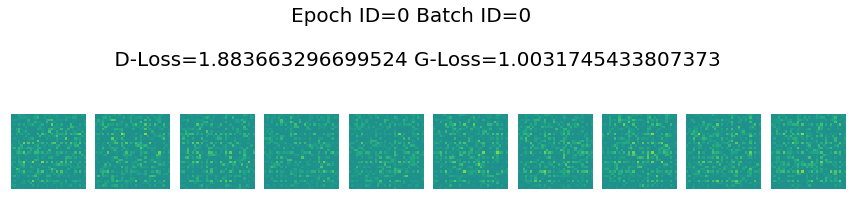

Epoch ID=0 Batch ID=1000 

 D-Loss=0.1555306613445282 G-Loss=0.5407826900482178


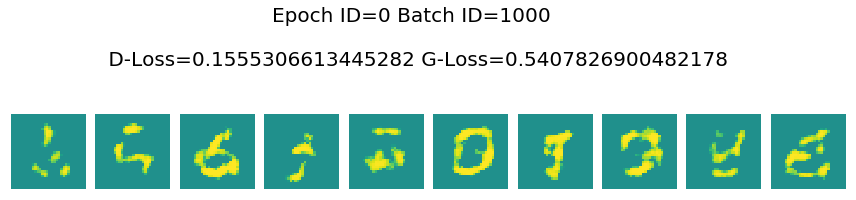

Epoch ID=1 Batch ID=0 

 D-Loss=0.13049492239952087 G-Loss=0.8821755647659302


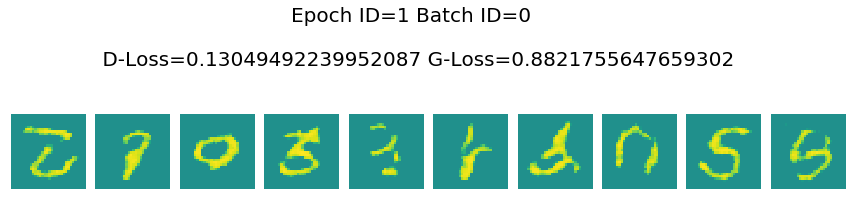

Epoch ID=1 Batch ID=1000 

 D-Loss=0.6970065832138062 G-Loss=0.80098557472229


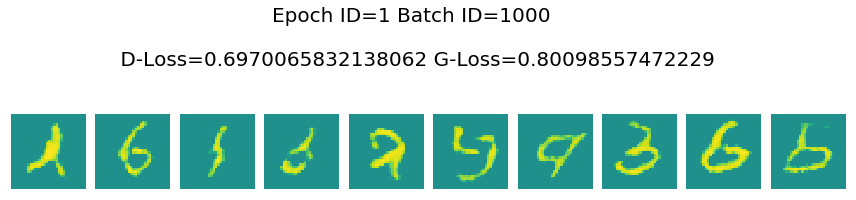

Epoch ID=2 Batch ID=0 

 D-Loss=0.1821516752243042 G-Loss=0.8782714605331421


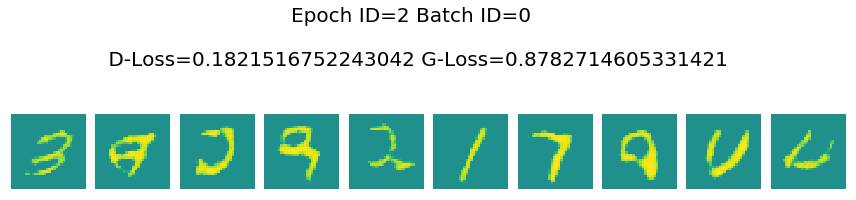

Epoch ID=2 Batch ID=1000 

 D-Loss=0.04319944232702255 G-Loss=0.8530997037887573


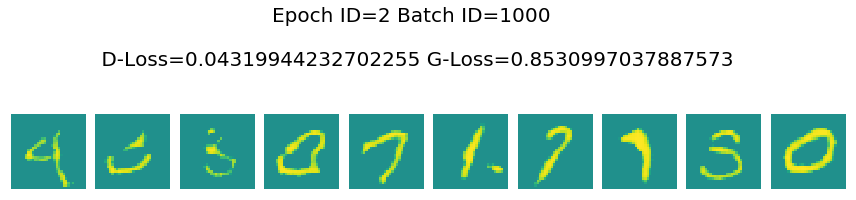

Epoch ID=3 Batch ID=0 

 D-Loss=0.08321975916624069 G-Loss=0.9277445673942566


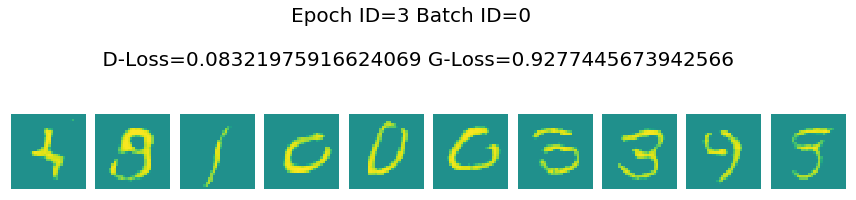

Epoch ID=3 Batch ID=1000 

 D-Loss=0.03134272247552872 G-Loss=0.9819056987762451


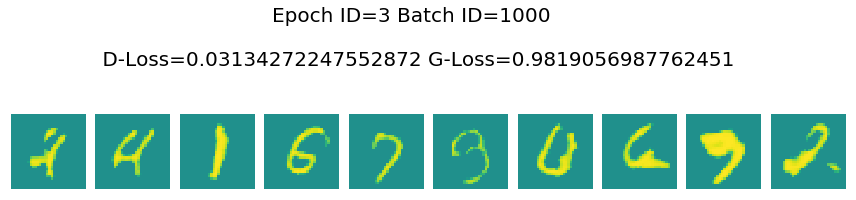

Epoch ID=4 Batch ID=0 

 D-Loss=0.03147509694099426 G-Loss=1.00356125831604


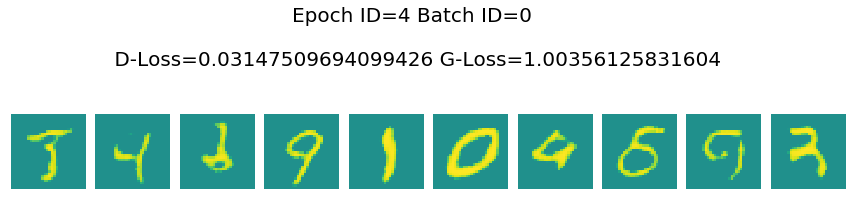

Epoch ID=4 Batch ID=1000 

 D-Loss=0.015433394350111485 G-Loss=1.0061838626861572


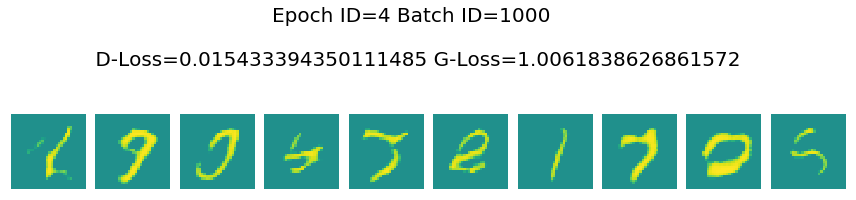

Epoch ID=5 Batch ID=0 

 D-Loss=0.013289239257574081 G-Loss=0.9964010715484619


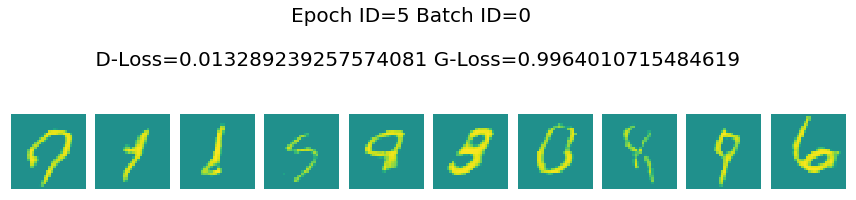

Epoch ID=5 Batch ID=1000 

 D-Loss=0.03677237406373024 G-Loss=0.9832606315612793


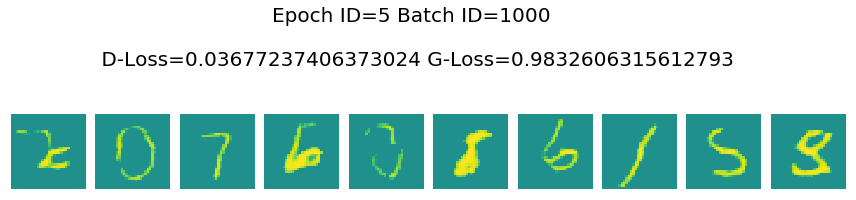

Epoch ID=6 Batch ID=0 

 D-Loss=0.13881975412368774 G-Loss=0.831706166267395


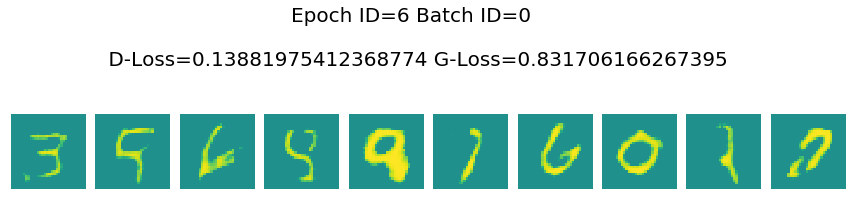

Epoch ID=6 Batch ID=1000 

 D-Loss=0.006792065687477589 G-Loss=1.0048861503601074


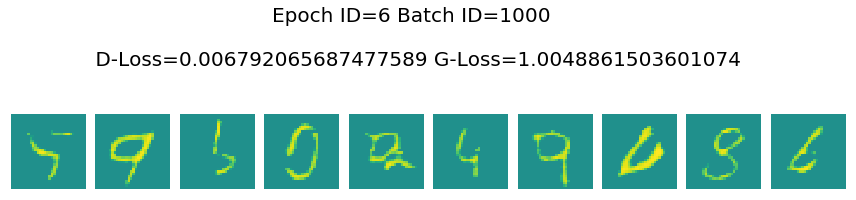

Epoch ID=7 Batch ID=0 

 D-Loss=0.005891617853194475 G-Loss=1.0061404705047607


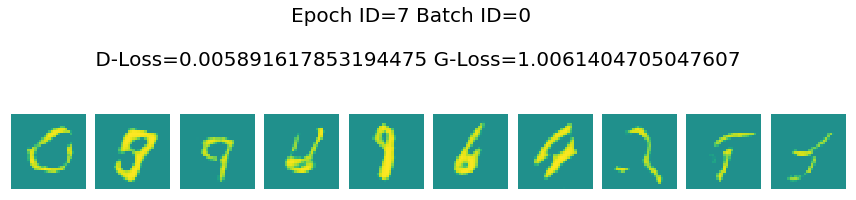

Epoch ID=7 Batch ID=1000 

 D-Loss=0.012173053808510303 G-Loss=0.9650326371192932


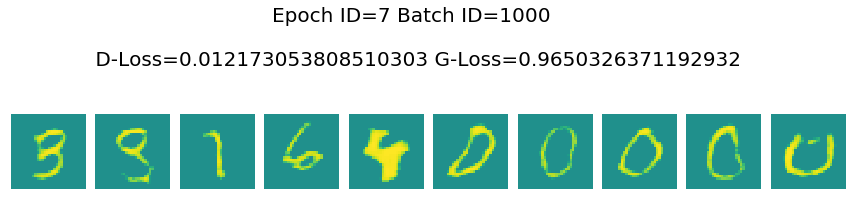

Epoch ID=8 Batch ID=0 

 D-Loss=0.026800435036420822 G-Loss=1.003627061843872


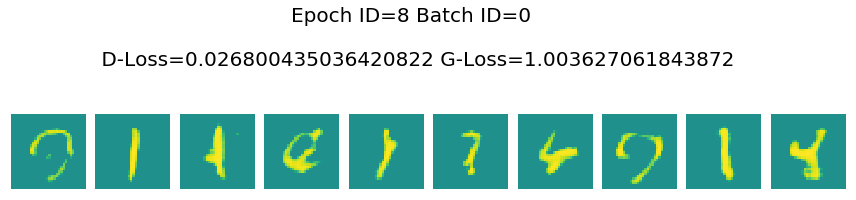

Epoch ID=8 Batch ID=1000 

 D-Loss=0.13269886374473572 G-Loss=0.45868605375289917


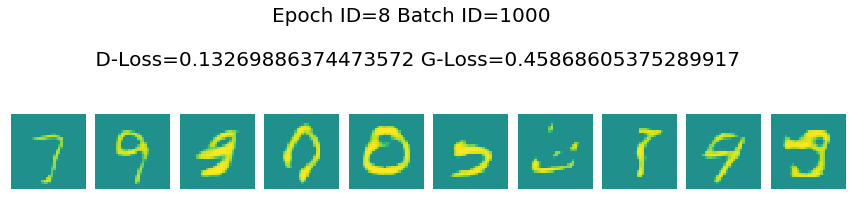

Epoch ID=9 Batch ID=0 

 D-Loss=0.035952284932136536 G-Loss=1.0097459554672241


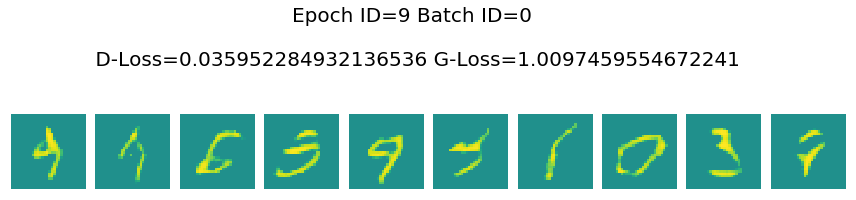

Epoch ID=9 Batch ID=1000 

 D-Loss=0.017632022500038147 G-Loss=0.991571307182312


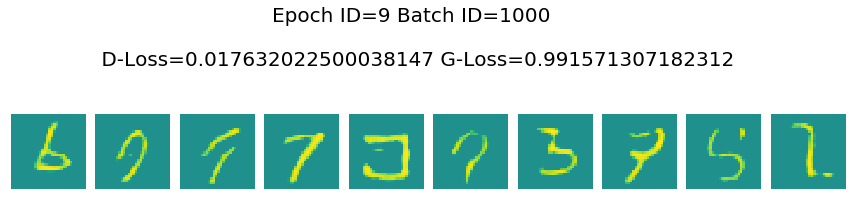

Epoch ID=10 Batch ID=0 

 D-Loss=0.008401188999414444 G-Loss=0.9396622180938721


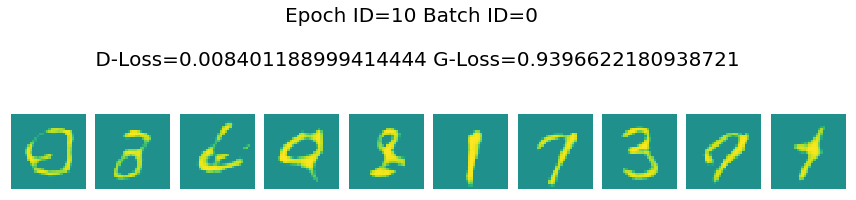

Epoch ID=10 Batch ID=1000 

 D-Loss=0.010098506696522236 G-Loss=1.0005719661712646


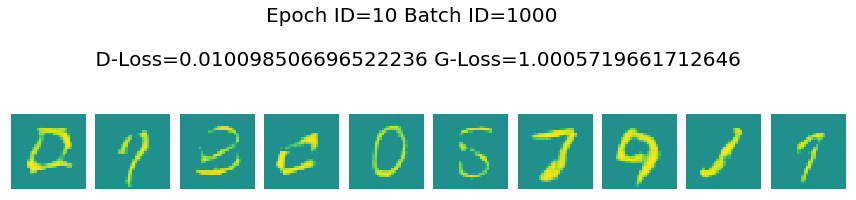

Epoch ID=11 Batch ID=0 

 D-Loss=0.3363075852394104 G-Loss=0.5326251983642578


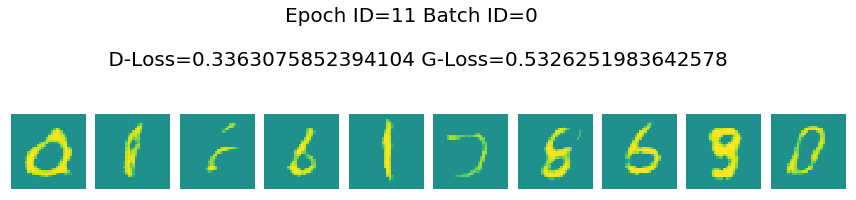

Epoch ID=11 Batch ID=1000 

 D-Loss=0.005874553229659796 G-Loss=1.0096514225006104


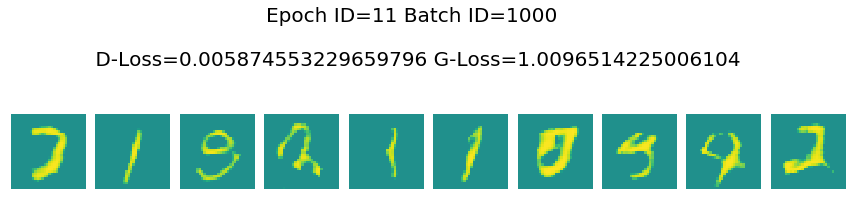

Epoch ID=12 Batch ID=0 

 D-Loss=0.007763209752738476 G-Loss=0.928093433380127


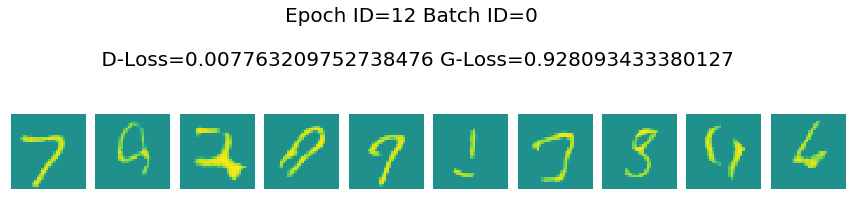

Epoch ID=12 Batch ID=1000 

 D-Loss=0.016376392915844917 G-Loss=1.0031815767288208


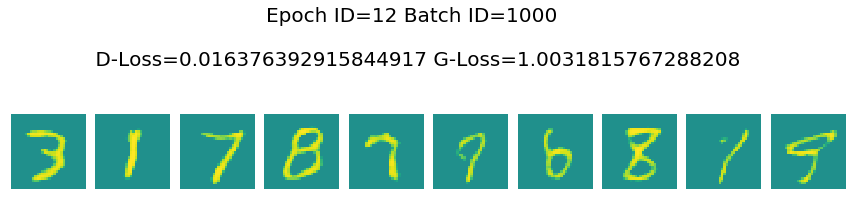

Epoch ID=13 Batch ID=0 

 D-Loss=0.005389452911913395 G-Loss=0.9670811295509338


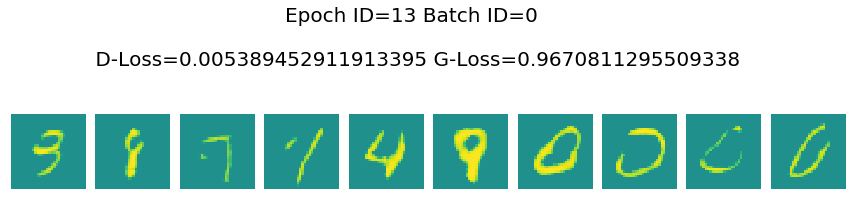

Epoch ID=13 Batch ID=1000 

 D-Loss=0.02035982720553875 G-Loss=1.0056614875793457


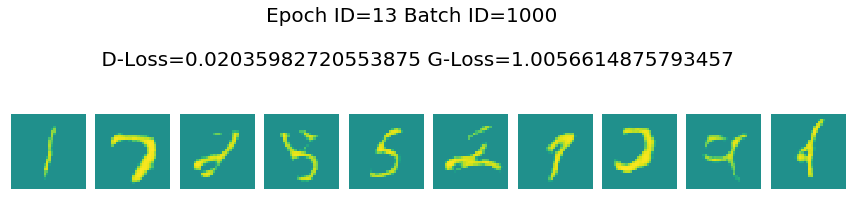

Epoch ID=14 Batch ID=0 

 D-Loss=0.06237390637397766 G-Loss=0.8691794276237488


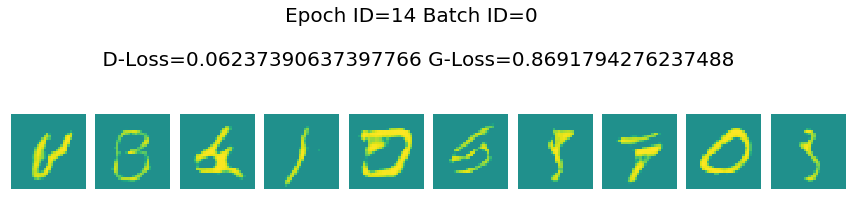

Epoch ID=14 Batch ID=1000 

 D-Loss=0.0073865195736289024 G-Loss=1.0073022842407227


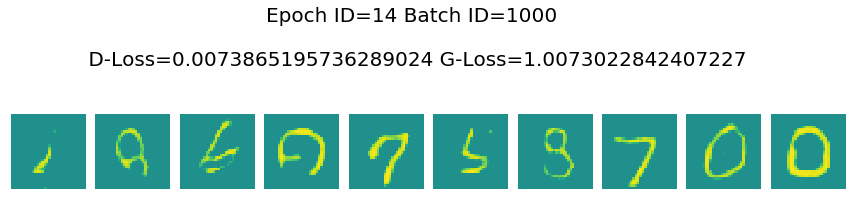

Epoch ID=15 Batch ID=0 

 D-Loss=0.005091890227049589 G-Loss=0.9976012110710144


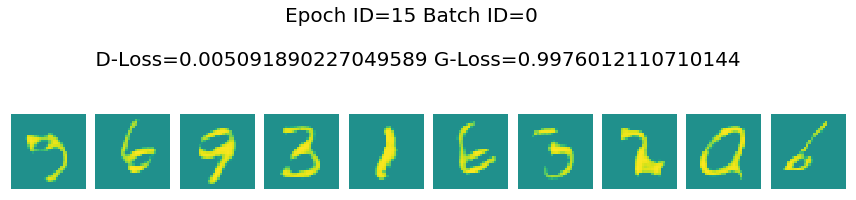

Epoch ID=15 Batch ID=1000 

 D-Loss=0.017163896933197975 G-Loss=0.9765352010726929


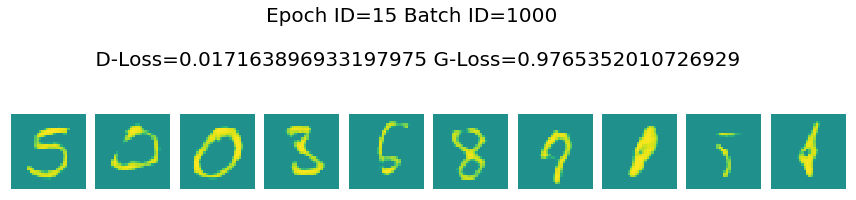

Epoch ID=16 Batch ID=0 

 D-Loss=0.0029811039566993713 G-Loss=0.9816163182258606


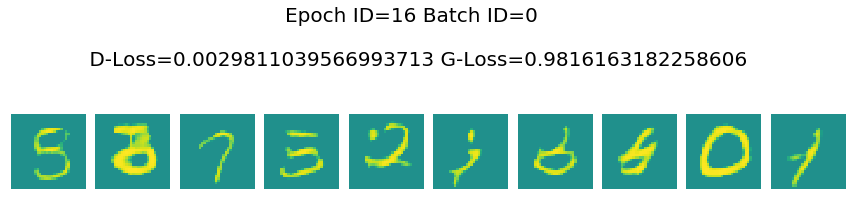

Epoch ID=16 Batch ID=1000 

 D-Loss=0.0013821282191202044 G-Loss=1.0094753503799438


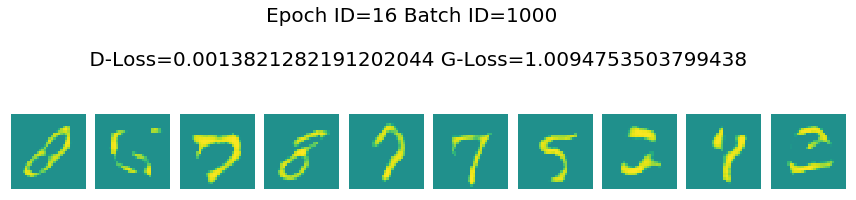

Epoch ID=17 Batch ID=0 

 D-Loss=0.005046586040407419 G-Loss=1.0074234008789062


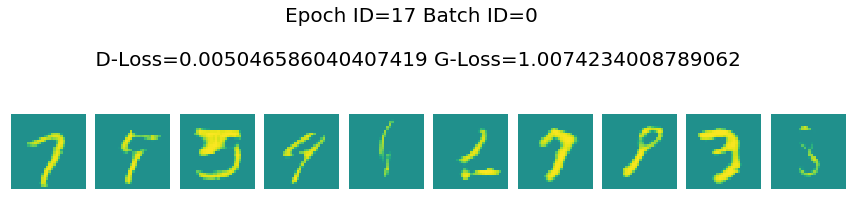

Epoch ID=17 Batch ID=1000 

 D-Loss=0.0043397885747253895 G-Loss=1.011676549911499


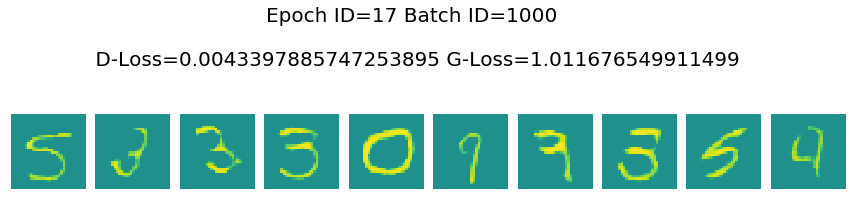

Epoch ID=18 Batch ID=0 

 D-Loss=0.0017850113799795508 G-Loss=1.0064377784729004


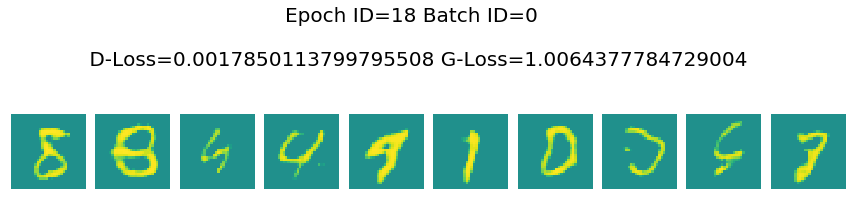

Epoch ID=18 Batch ID=1000 

 D-Loss=0.19614137709140778 G-Loss=0.9816175699234009


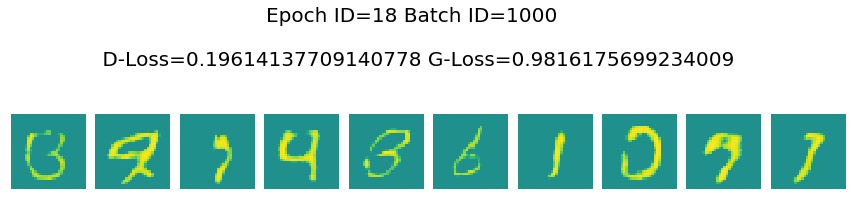

Epoch ID=19 Batch ID=0 

 D-Loss=0.015485396608710289 G-Loss=1.0078352689743042


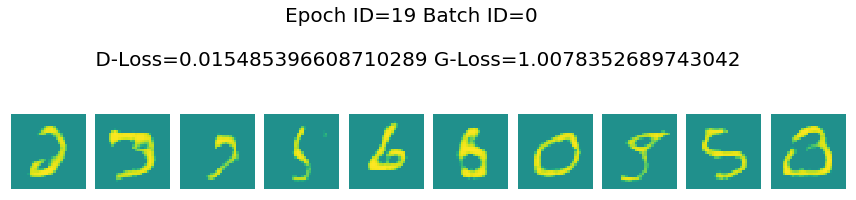

Epoch ID=19 Batch ID=1000 

 D-Loss=0.007577490992844105 G-Loss=1.000481128692627


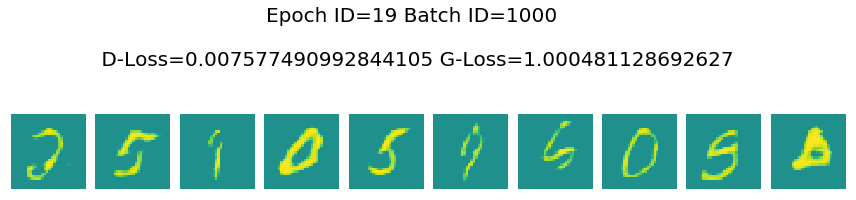

Epoch ID=20 Batch ID=0 

 D-Loss=0.9545915722846985 G-Loss=0.9728658199310303


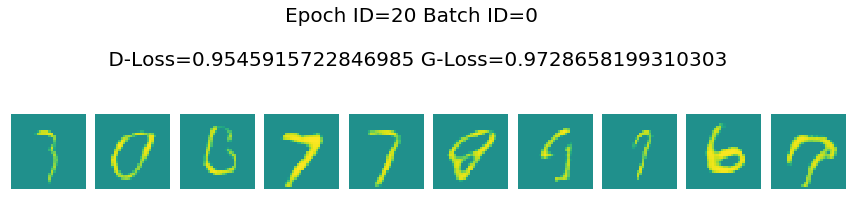

Epoch ID=20 Batch ID=1000 

 D-Loss=0.0064583043567836285 G-Loss=0.9871397614479065


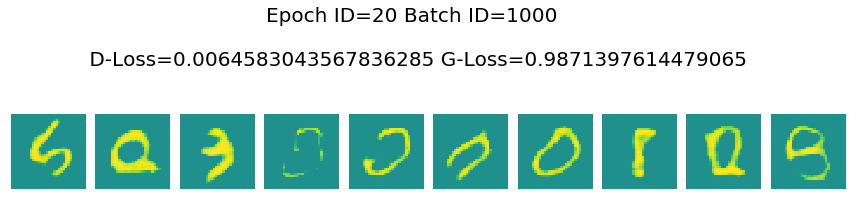

Epoch ID=21 Batch ID=0 

 D-Loss=0.006779447663575411 G-Loss=0.9707319736480713


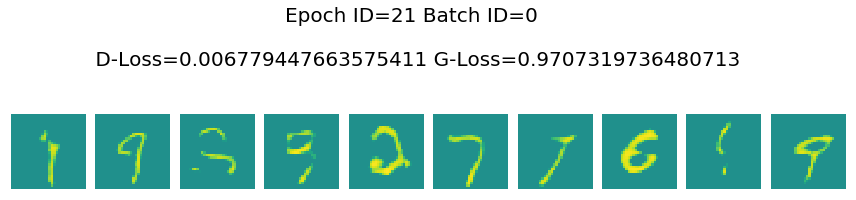

Epoch ID=21 Batch ID=1000 

 D-Loss=0.018682211637496948 G-Loss=1.00475013256073


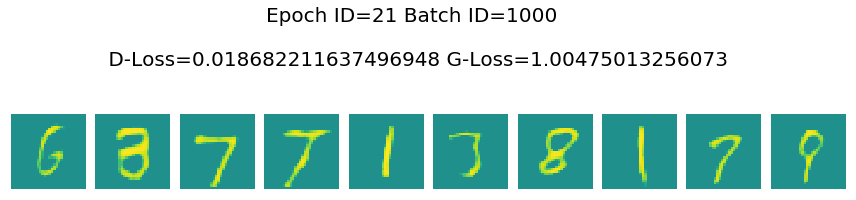

Epoch ID=22 Batch ID=0 

 D-Loss=0.010818489827215672 G-Loss=1.0028252601623535


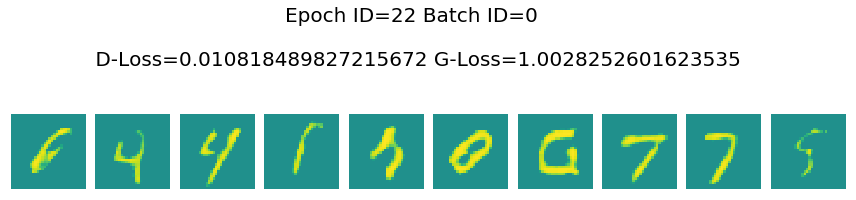

Epoch ID=22 Batch ID=1000 

 D-Loss=0.003965994343161583 G-Loss=0.9993013143539429


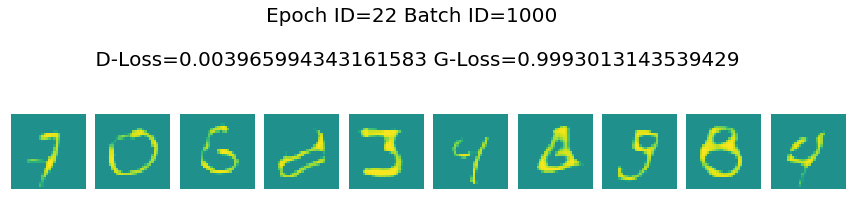

Epoch ID=23 Batch ID=0 

 D-Loss=0.0020265113562345505 G-Loss=1.0047798156738281


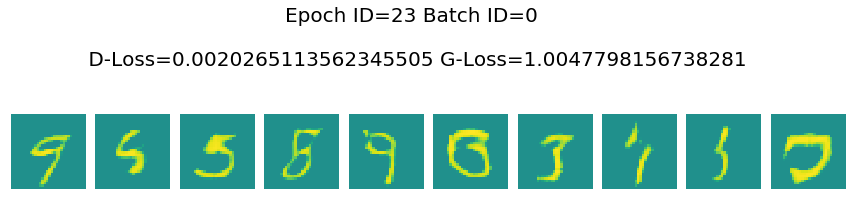

Epoch ID=23 Batch ID=1000 

 D-Loss=0.0047607324086129665 G-Loss=1.012695074081421


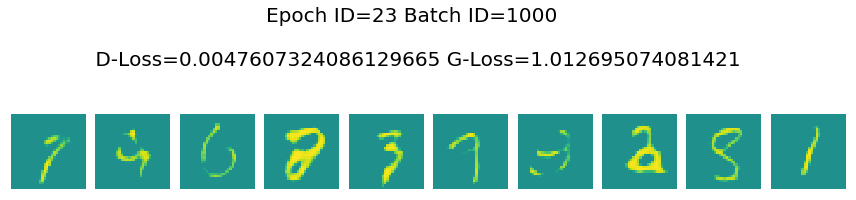

Epoch ID=24 Batch ID=0 

 D-Loss=0.007654265966266394 G-Loss=0.995197057723999


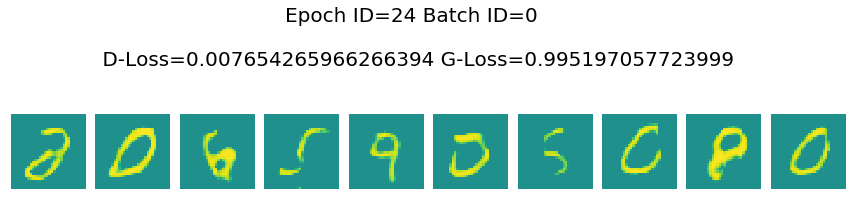

Epoch ID=24 Batch ID=1000 

 D-Loss=0.02638901397585869 G-Loss=1.0080465078353882


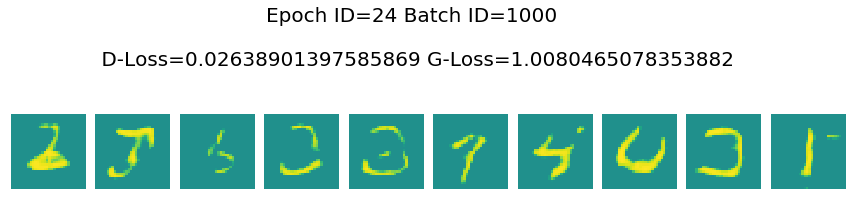

Epoch ID=25 Batch ID=0 

 D-Loss=0.006440530531108379 G-Loss=1.0029715299606323


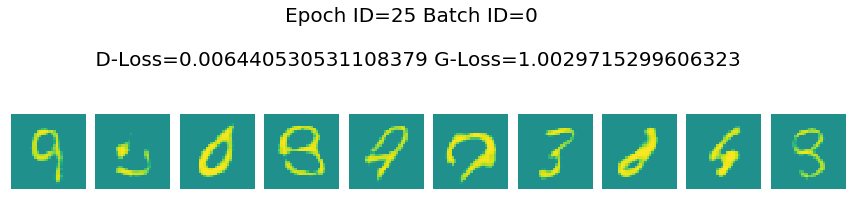

Epoch ID=25 Batch ID=1000 

 D-Loss=0.004240137524902821 G-Loss=1.0042316913604736


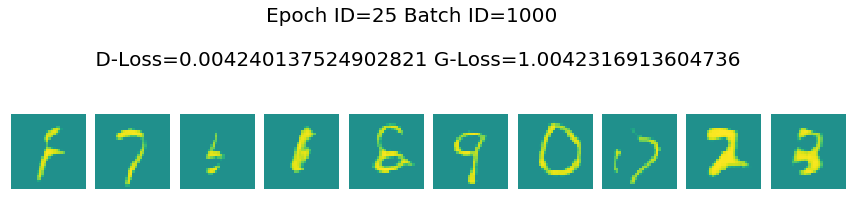

Epoch ID=26 Batch ID=0 

 D-Loss=0.008709462359547615 G-Loss=1.0026698112487793


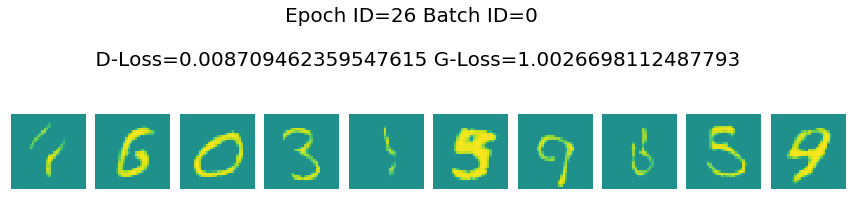

Epoch ID=26 Batch ID=1000 

 D-Loss=0.00450937869027257 G-Loss=1.005786418914795


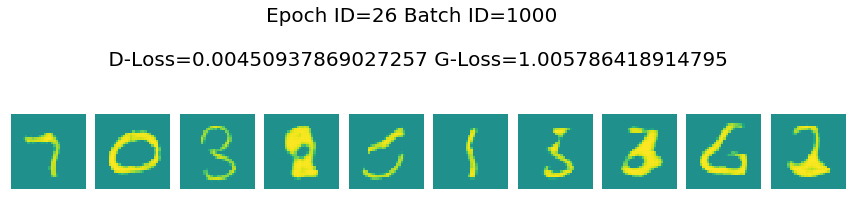

Epoch ID=27 Batch ID=0 

 D-Loss=0.002297754632309079 G-Loss=0.9715622067451477


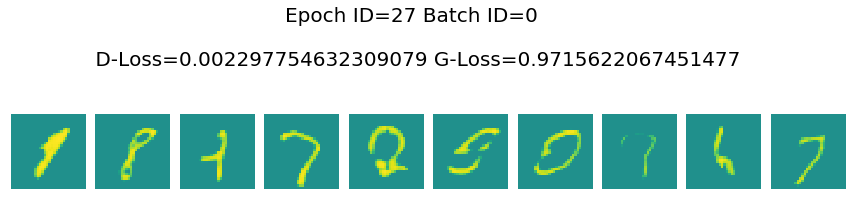

Epoch ID=27 Batch ID=1000 

 D-Loss=0.0026019643992185593 G-Loss=1.003523349761963


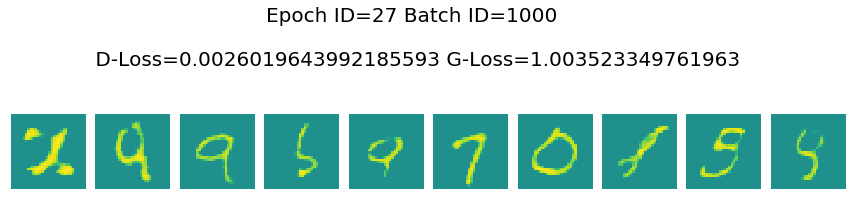

Epoch ID=28 Batch ID=0 

 D-Loss=0.0068504768423736095 G-Loss=1.00017249584198


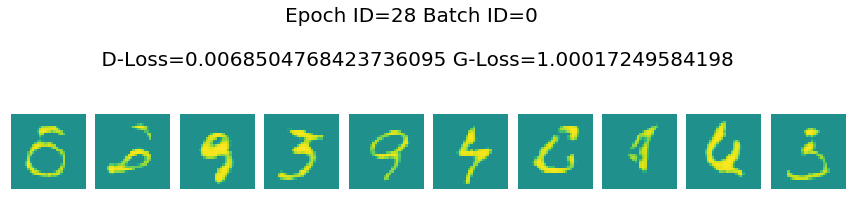

Epoch ID=28 Batch ID=1000 

 D-Loss=0.0016390802338719368 G-Loss=0.9775441884994507


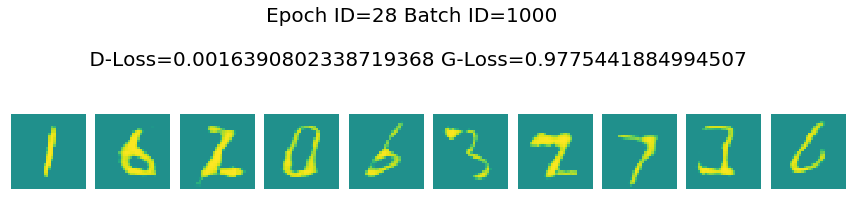

Epoch ID=29 Batch ID=0 

 D-Loss=0.0016983570531010628 G-Loss=1.0018682479858398


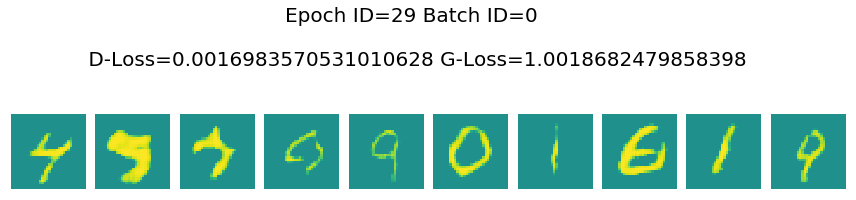

Epoch ID=29 Batch ID=1000 

 D-Loss=0.015514904633164406 G-Loss=1.0070163011550903


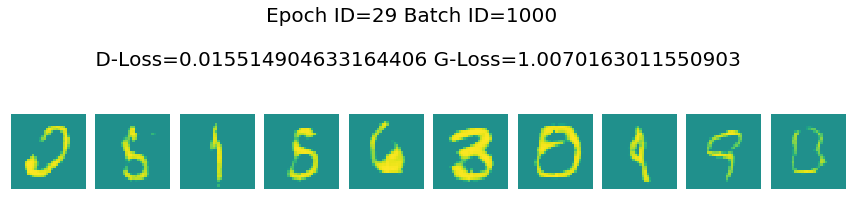

Epoch ID=30 Batch ID=0 

 D-Loss=0.006053789984434843 G-Loss=1.0064725875854492


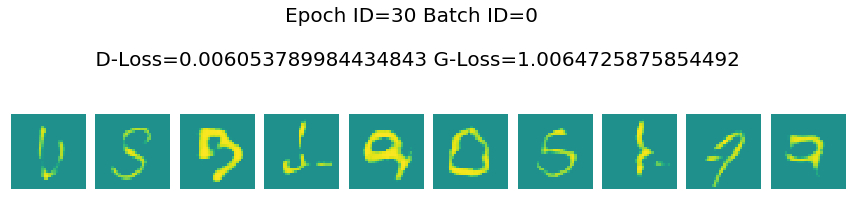

Epoch ID=30 Batch ID=1000 

 D-Loss=0.007390379905700684 G-Loss=0.9897220730781555


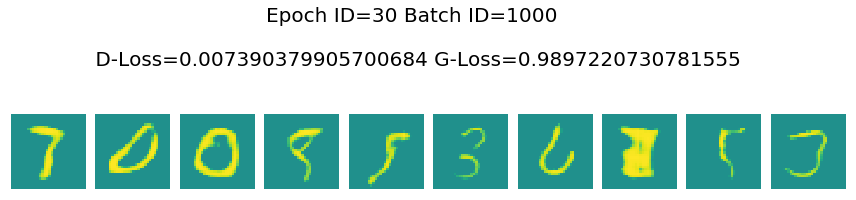

Epoch ID=31 Batch ID=0 

 D-Loss=0.008941957727074623 G-Loss=1.0024120807647705


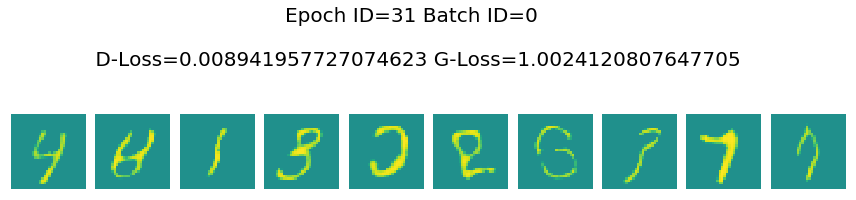

Epoch ID=31 Batch ID=1000 

 D-Loss=0.011102578602731228 G-Loss=0.9671097993850708


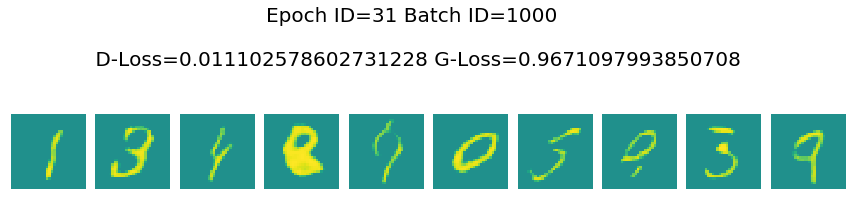

Epoch ID=32 Batch ID=0 

 D-Loss=0.012305958196520805 G-Loss=1.006591558456421


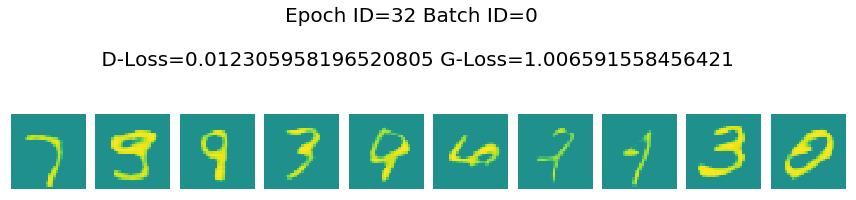

Epoch ID=32 Batch ID=1000 

 D-Loss=0.002883664332330227 G-Loss=1.0094815492630005


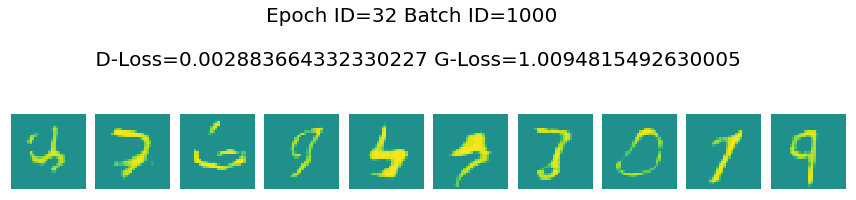

Epoch ID=33 Batch ID=0 

 D-Loss=0.0021114973351359367 G-Loss=0.997260570526123


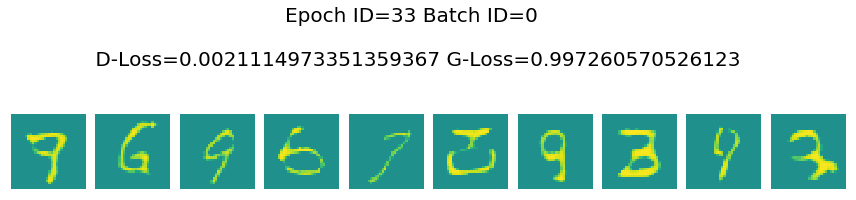

Epoch ID=33 Batch ID=1000 

 D-Loss=0.0018638630863279104 G-Loss=1.0093889236450195


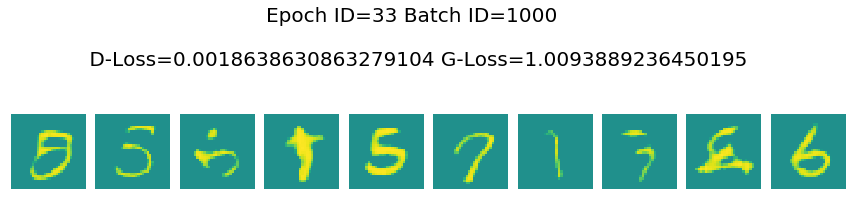

Epoch ID=34 Batch ID=0 

 D-Loss=0.002341052982956171 G-Loss=1.014054536819458


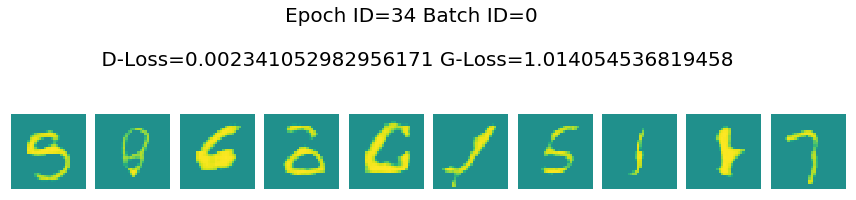

Epoch ID=34 Batch ID=1000 

 D-Loss=0.0035016476176679134 G-Loss=1.0041885375976562


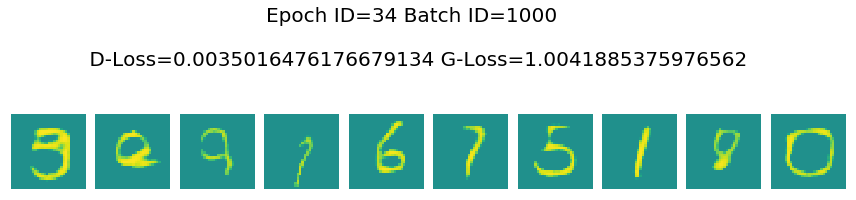

Epoch ID=35 Batch ID=0 

 D-Loss=0.030061591416597366 G-Loss=0.9391399025917053


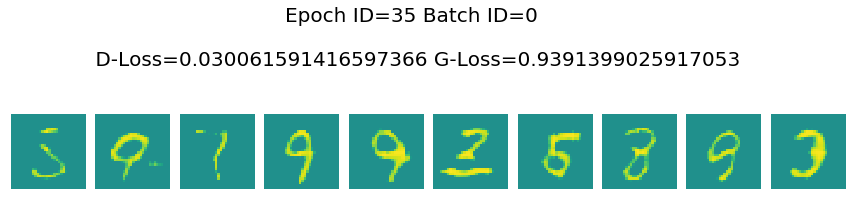

Epoch ID=35 Batch ID=1000 

 D-Loss=0.003205455606803298 G-Loss=1.0072052478790283


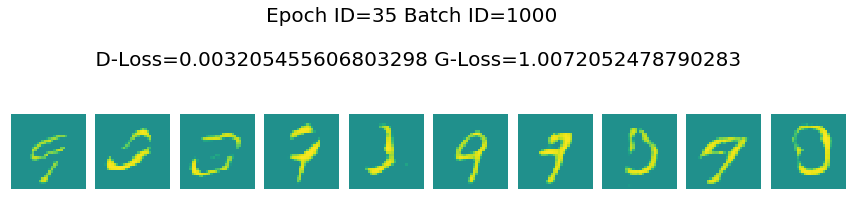

Epoch ID=36 Batch ID=0 

 D-Loss=0.0033382612746208906 G-Loss=0.9956328868865967


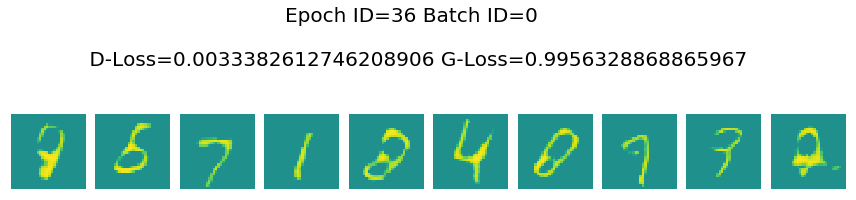

Epoch ID=36 Batch ID=1000 

 D-Loss=0.06551865488290787 G-Loss=0.967084527015686


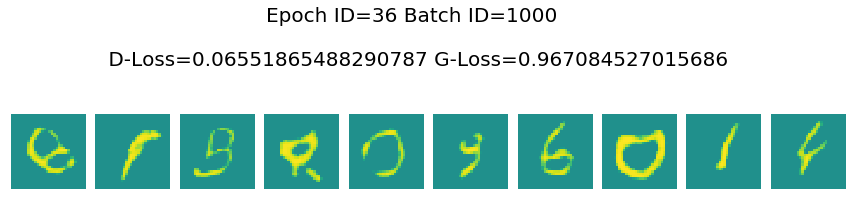

Epoch ID=37 Batch ID=0 

 D-Loss=0.003048463026061654 G-Loss=1.011878252029419


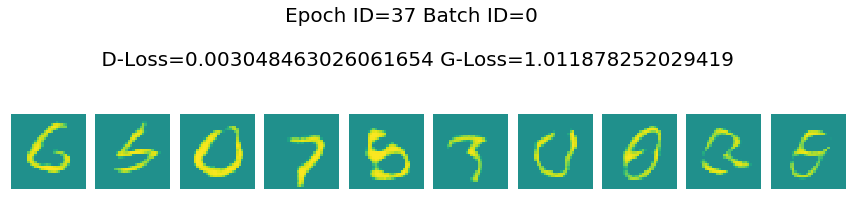

Epoch ID=37 Batch ID=1000 

 D-Loss=0.002575228689238429 G-Loss=1.006035327911377


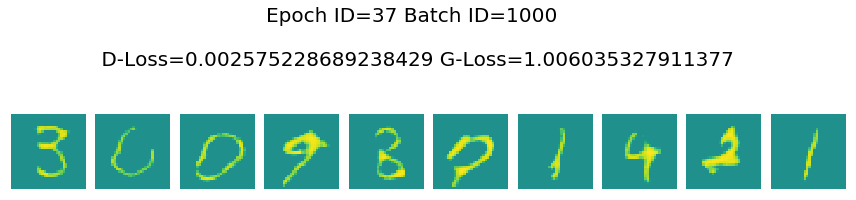

Epoch ID=38 Batch ID=0 

 D-Loss=0.008076585829257965 G-Loss=1.0049902200698853


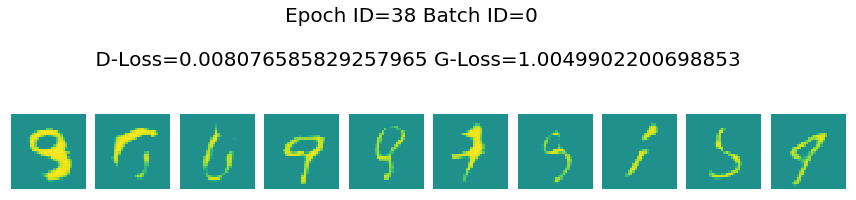

Epoch ID=38 Batch ID=1000 

 D-Loss=0.005344890523701906 G-Loss=0.9821076393127441


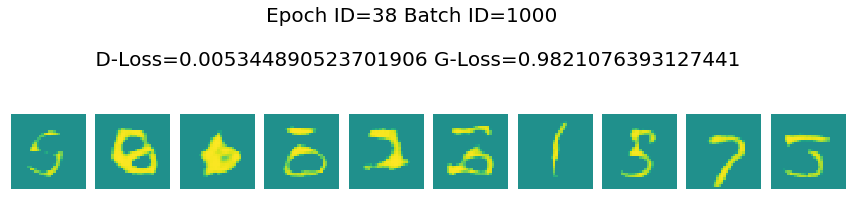

Epoch ID=39 Batch ID=0 

 D-Loss=0.009070123545825481 G-Loss=1.0041897296905518


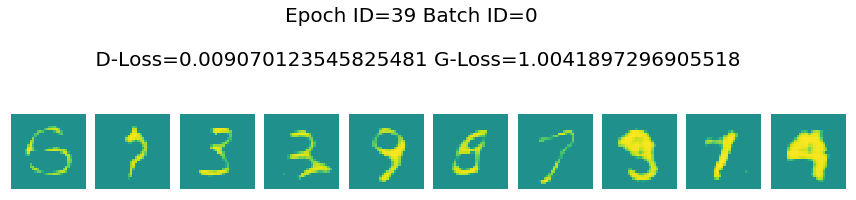

Epoch ID=39 Batch ID=1000 

 D-Loss=0.004433787427842617 G-Loss=1.0117015838623047


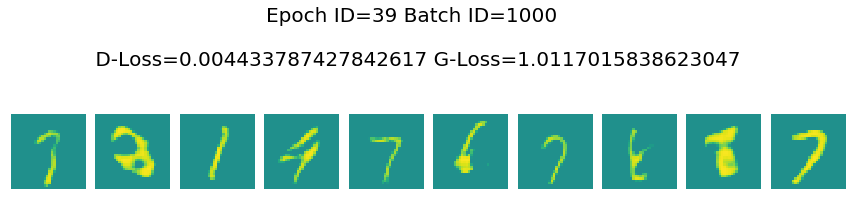

Epoch ID=40 Batch ID=0 

 D-Loss=0.0032326821237802505 G-Loss=1.0046275854110718


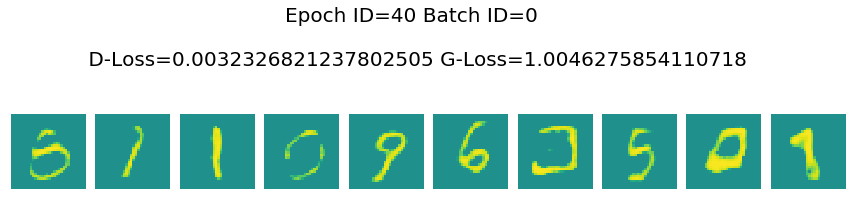

Epoch ID=40 Batch ID=1000 

 D-Loss=0.0026550046168267727 G-Loss=1.0092155933380127


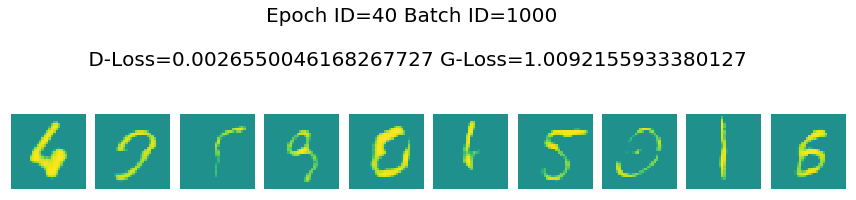

Epoch ID=41 Batch ID=0 

 D-Loss=0.0008682832703925669 G-Loss=1.0053718090057373


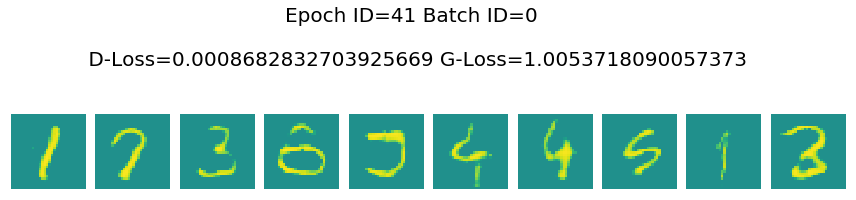

Epoch ID=41 Batch ID=1000 

 D-Loss=0.0034776043612509966 G-Loss=1.000749111175537


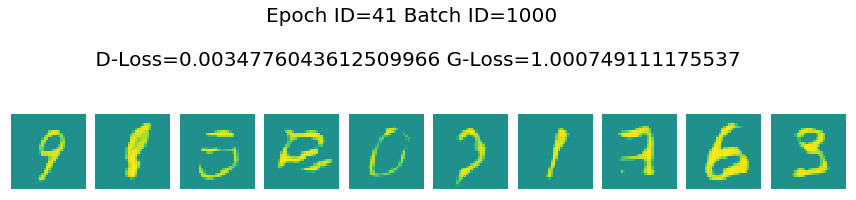

Epoch ID=42 Batch ID=0 

 D-Loss=0.0018586140358820558 G-Loss=1.0041277408599854


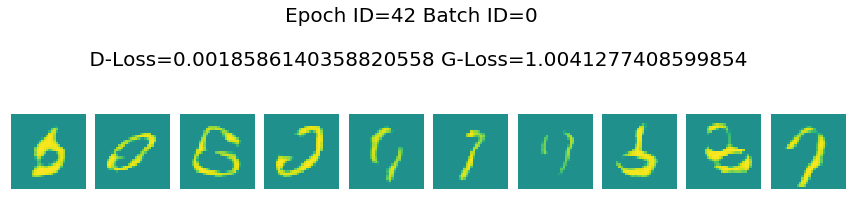

Epoch ID=42 Batch ID=1000 

 D-Loss=0.0011139330454170704 G-Loss=1.0082162618637085


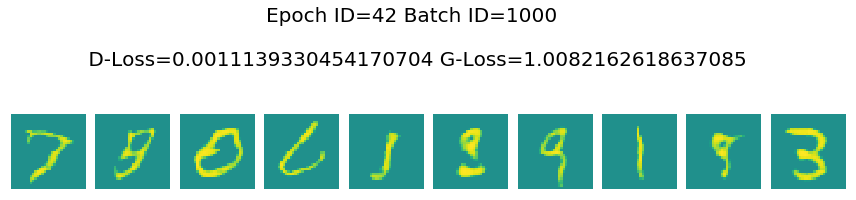

Epoch ID=43 Batch ID=0 

 D-Loss=0.002571970224380493 G-Loss=1.0014195442199707


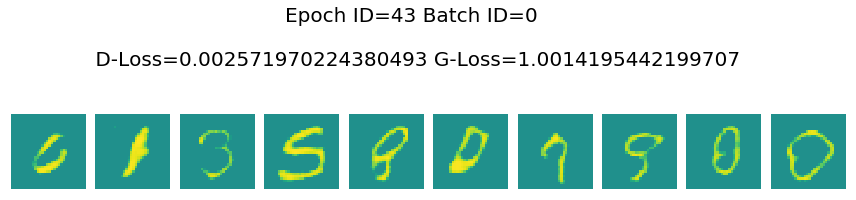

Epoch ID=43 Batch ID=1000 

 D-Loss=0.00414974195882678 G-Loss=1.013696551322937


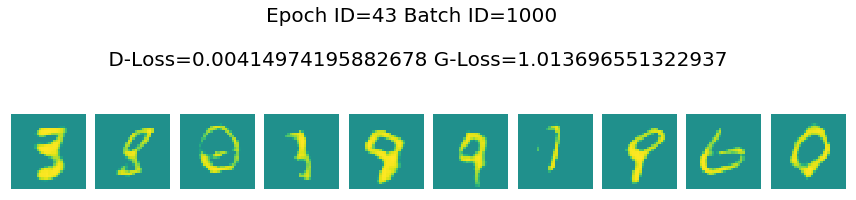

Epoch ID=44 Batch ID=0 

 D-Loss=0.006149205379188061 G-Loss=0.9876148700714111


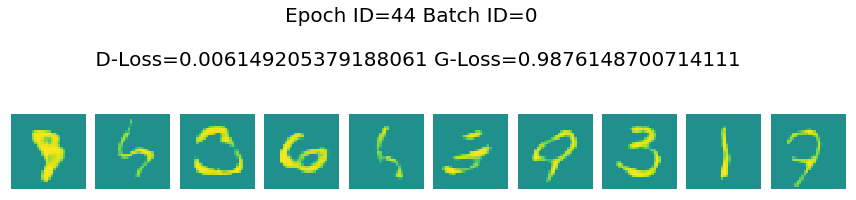

Epoch ID=44 Batch ID=1000 

 D-Loss=0.0023334193974733353 G-Loss=1.0063068866729736


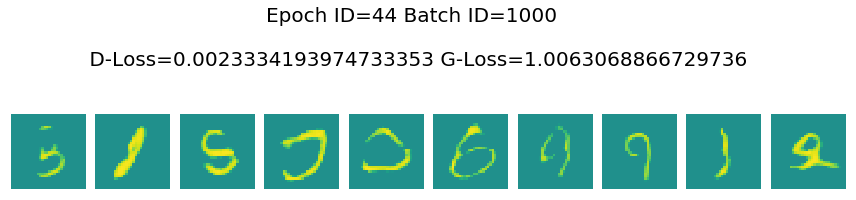

Epoch ID=45 Batch ID=0 

 D-Loss=0.001339494250714779 G-Loss=1.003124713897705


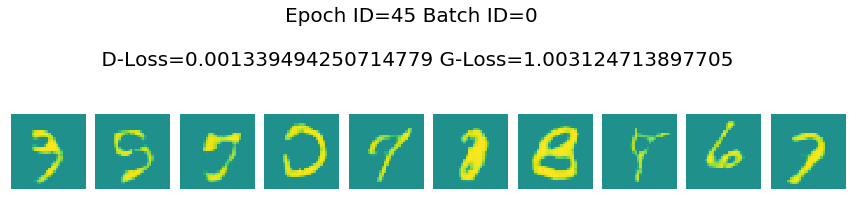

Epoch ID=45 Batch ID=1000 

 D-Loss=0.00147392472717911 G-Loss=0.9703908562660217


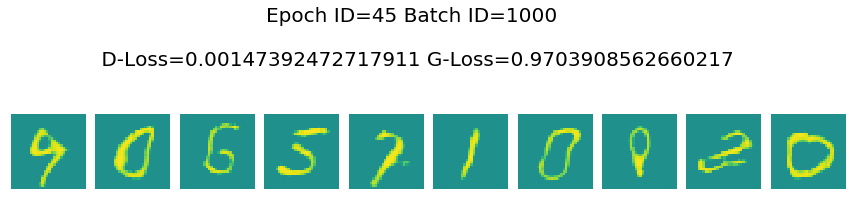

Epoch ID=46 Batch ID=0 

 D-Loss=0.0003838878474198282 G-Loss=1.0033063888549805


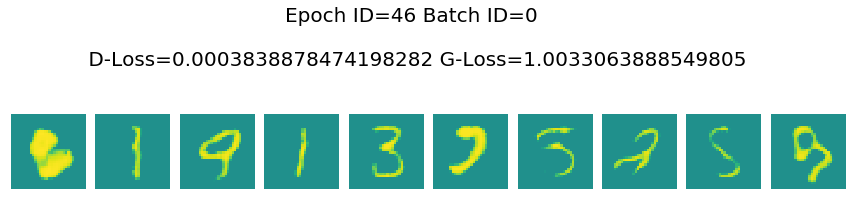

Epoch ID=46 Batch ID=1000 

 D-Loss=0.0028027386870235205 G-Loss=1.0024373531341553


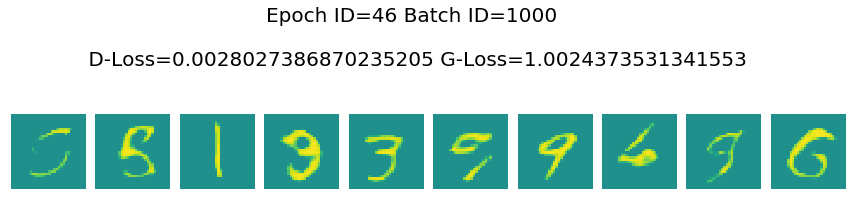

Epoch ID=47 Batch ID=0 

 D-Loss=0.004268644843250513 G-Loss=1.0037273168563843


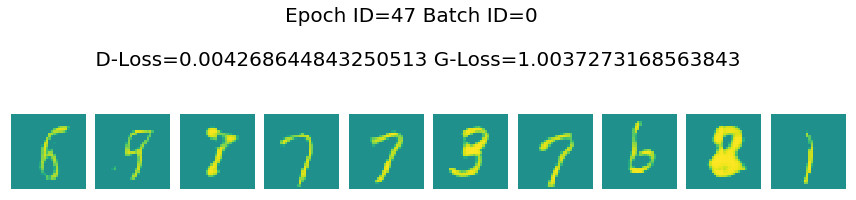

Epoch ID=47 Batch ID=1000 

 D-Loss=0.0018234195886179805 G-Loss=1.0109329223632812


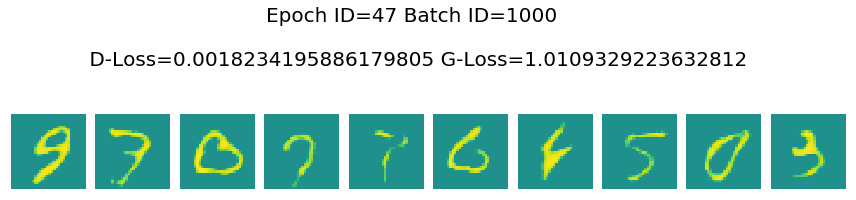

Epoch ID=48 Batch ID=0 

 D-Loss=0.0016309947241097689 G-Loss=0.9744908213615417


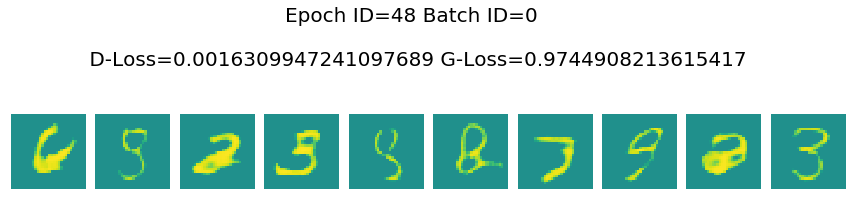

Epoch ID=48 Batch ID=1000 

 D-Loss=0.0010108804563060403 G-Loss=1.0021958351135254


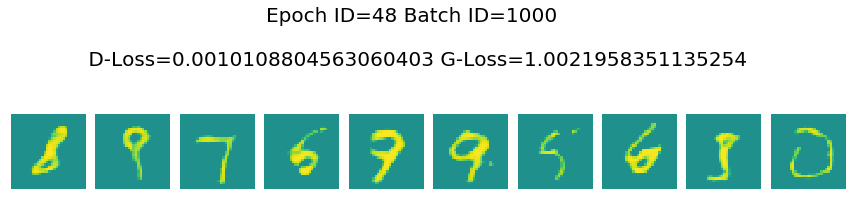

Epoch ID=49 Batch ID=0 

 D-Loss=0.0027579958550632 G-Loss=1.009267807006836


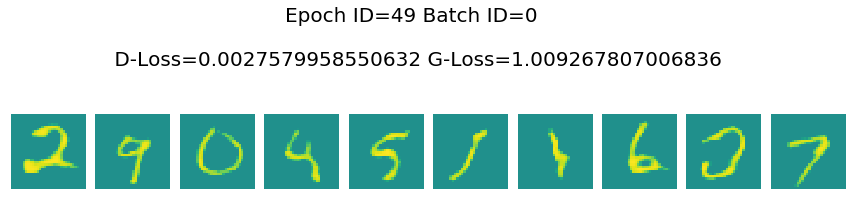

Epoch ID=49 Batch ID=1000 

 D-Loss=0.004345426335930824 G-Loss=1.0085060596466064


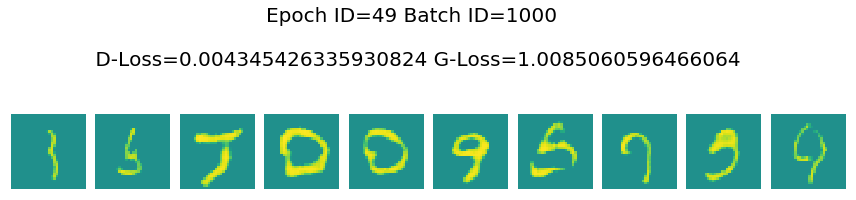

Epoch ID=50 Batch ID=0 

 D-Loss=0.0024593838024884462 G-Loss=1.0050358772277832


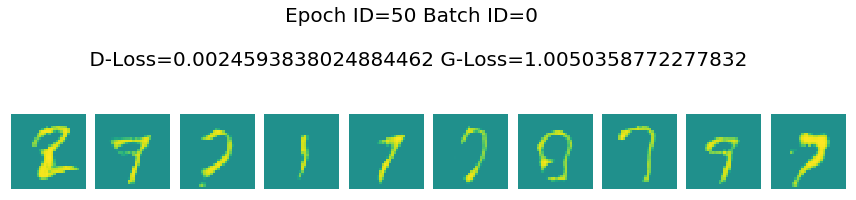

Epoch ID=50 Batch ID=1000 

 D-Loss=0.0043841577135026455 G-Loss=1.0039293766021729


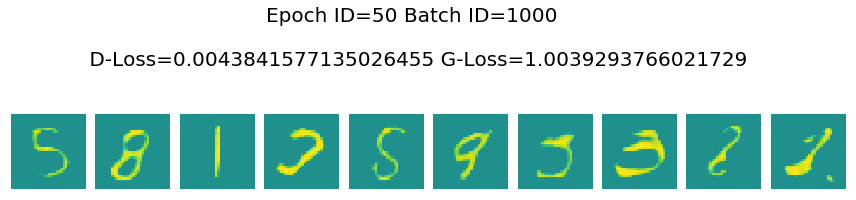

Epoch ID=51 Batch ID=0 

 D-Loss=0.010761366225779057 G-Loss=0.998207688331604


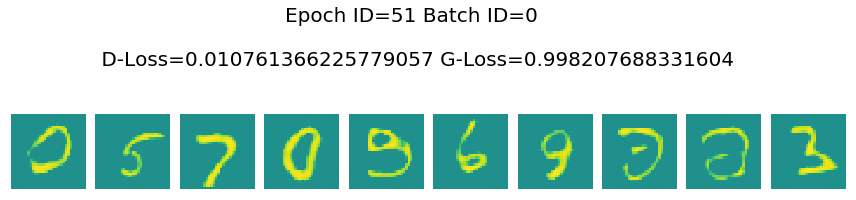

Epoch ID=51 Batch ID=1000 

 D-Loss=0.001035074470564723 G-Loss=1.0046355724334717


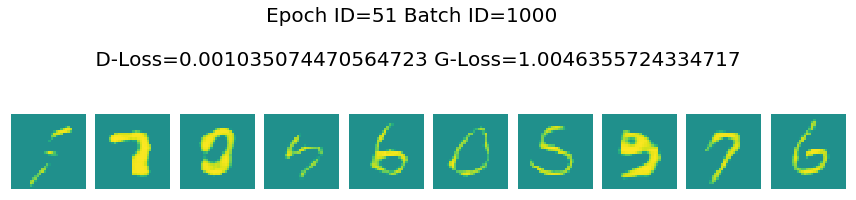

Epoch ID=52 Batch ID=0 

 D-Loss=0.0010121280793100595 G-Loss=1.0053220987319946


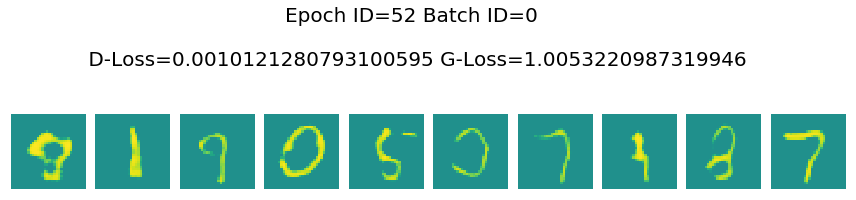

Epoch ID=52 Batch ID=1000 

 D-Loss=0.0005198410362936556 G-Loss=1.0037058591842651


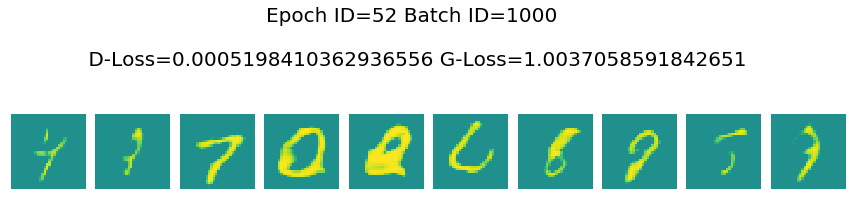

Epoch ID=53 Batch ID=0 

 D-Loss=0.0058134919963777065 G-Loss=1.0054314136505127


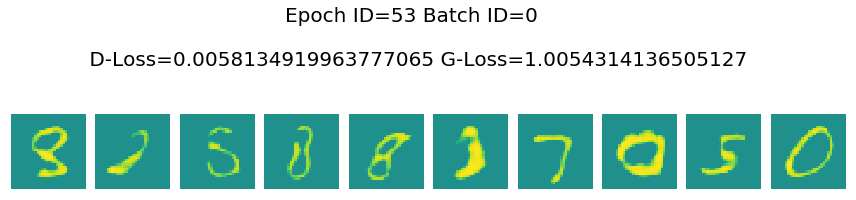

Epoch ID=53 Batch ID=1000 

 D-Loss=0.0015210743295028806 G-Loss=1.004472017288208


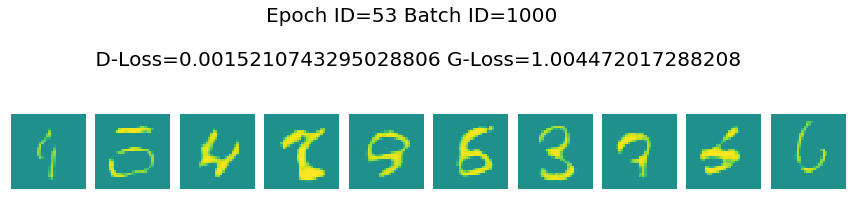

Epoch ID=54 Batch ID=0 

 D-Loss=0.0006685387925244868 G-Loss=1.007881999015808


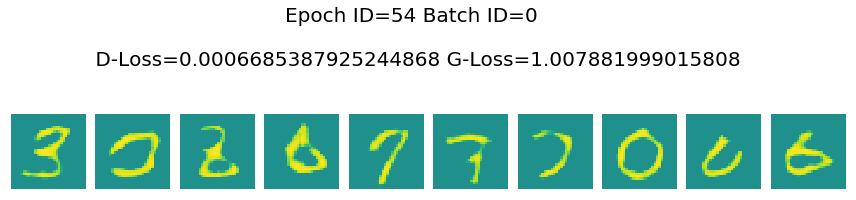

Epoch ID=54 Batch ID=1000 

 D-Loss=0.004653544165194035 G-Loss=1.0067781209945679


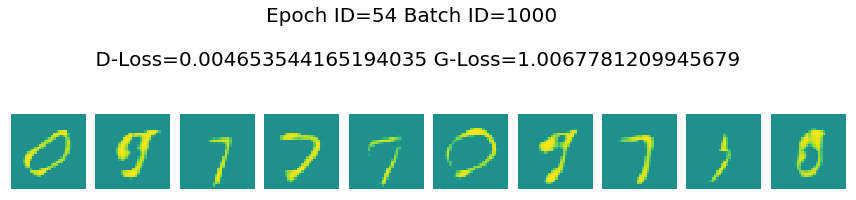

Epoch ID=55 Batch ID=0 

 D-Loss=0.0007671428029425442 G-Loss=1.0022966861724854


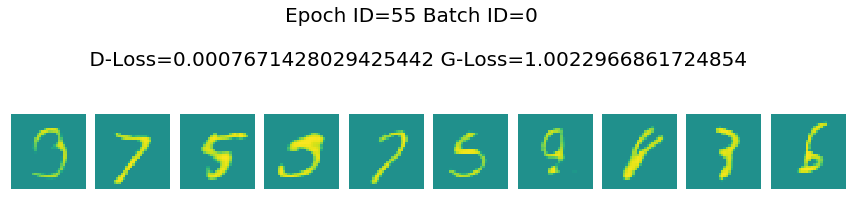

Epoch ID=55 Batch ID=1000 

 D-Loss=0.010401261039078236 G-Loss=1.0102168321609497


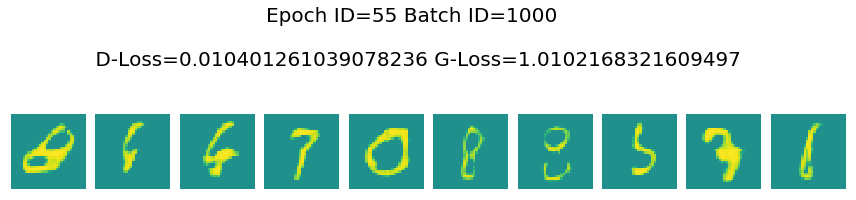

Epoch ID=56 Batch ID=0 

 D-Loss=0.0008388214628212154 G-Loss=1.0078425407409668


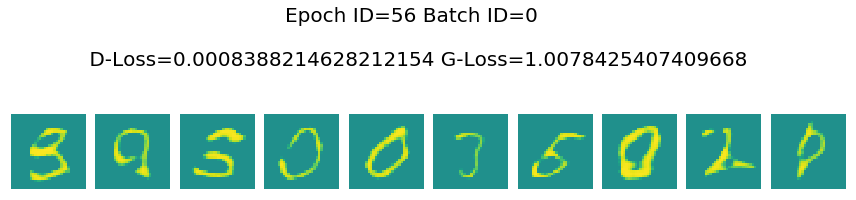

Epoch ID=56 Batch ID=1000 

 D-Loss=0.0004422422789502889 G-Loss=1.0159997940063477


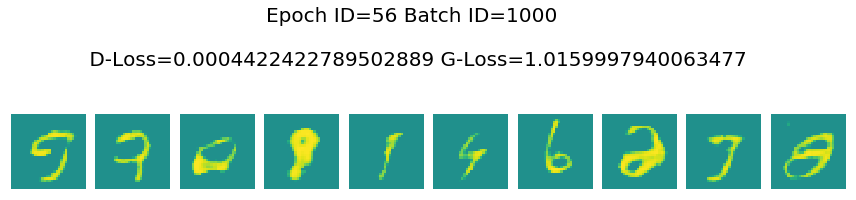

Epoch ID=57 Batch ID=0 

 D-Loss=0.0015843529254198074 G-Loss=0.9977266788482666


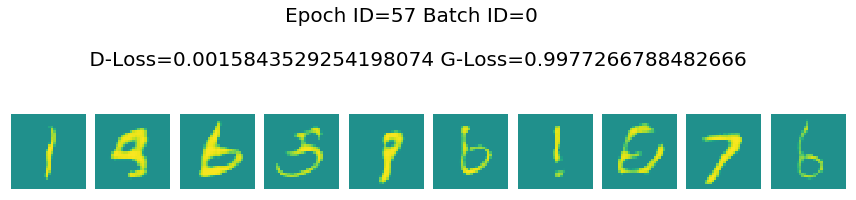

Epoch ID=57 Batch ID=1000 

 D-Loss=0.0012805957812815905 G-Loss=1.0033817291259766


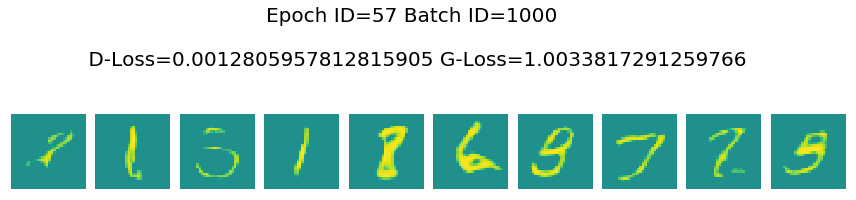

Epoch ID=58 Batch ID=0 

 D-Loss=0.0009575076983310282 G-Loss=0.9987939596176147


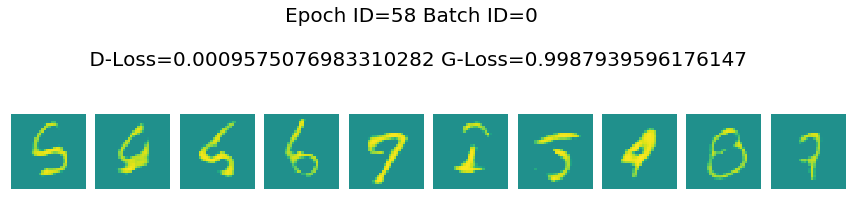

Epoch ID=58 Batch ID=1000 

 D-Loss=0.0019520065980032086 G-Loss=1.0140438079833984


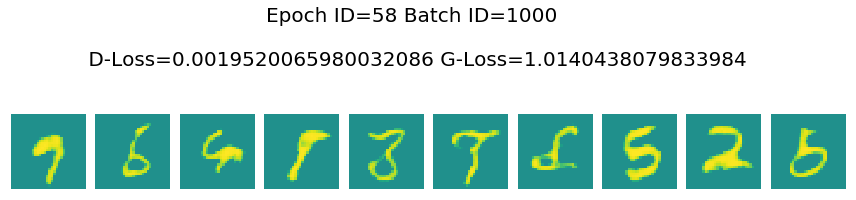

Epoch ID=59 Batch ID=0 

 D-Loss=0.0005939759430475533 G-Loss=1.010135293006897


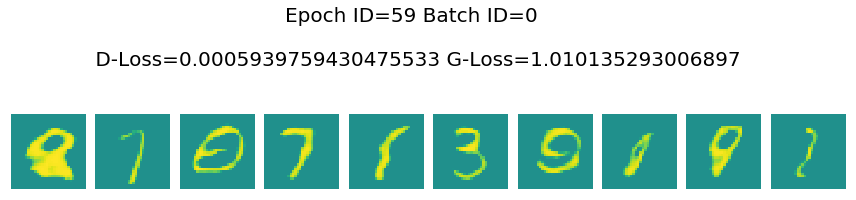

Epoch ID=59 Batch ID=1000 

 D-Loss=0.0008464379352517426 G-Loss=1.001978874206543


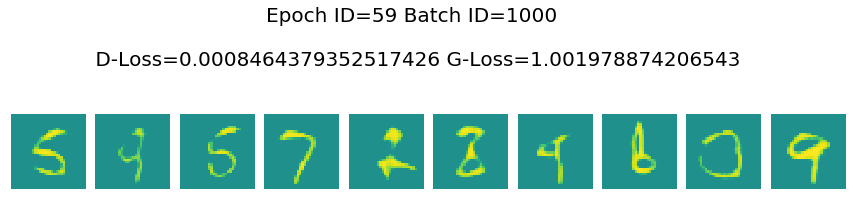

Epoch ID=60 Batch ID=0 

 D-Loss=0.0012756962096318603 G-Loss=1.005915880203247


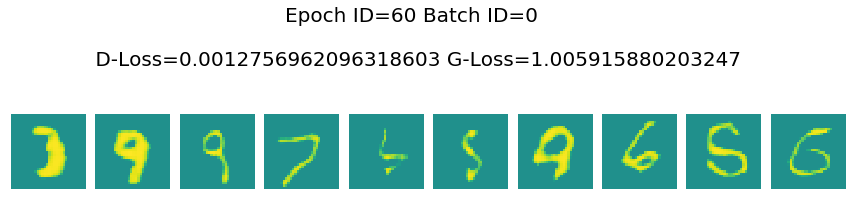

Epoch ID=60 Batch ID=1000 

 D-Loss=0.0009548217640258372 G-Loss=1.0045768022537231


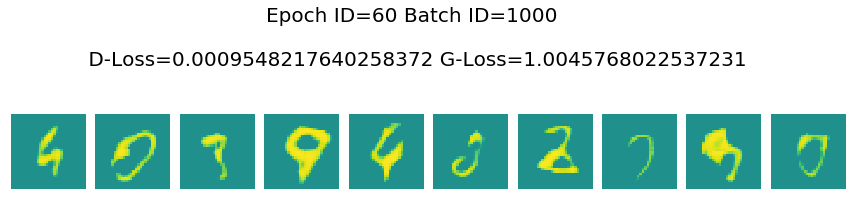

Epoch ID=61 Batch ID=0 

 D-Loss=0.00043078220915049314 G-Loss=1.011552333831787


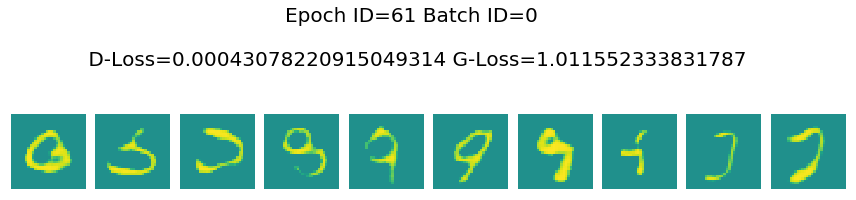

Epoch ID=61 Batch ID=1000 

 D-Loss=0.0024355356581509113 G-Loss=1.0029195547103882


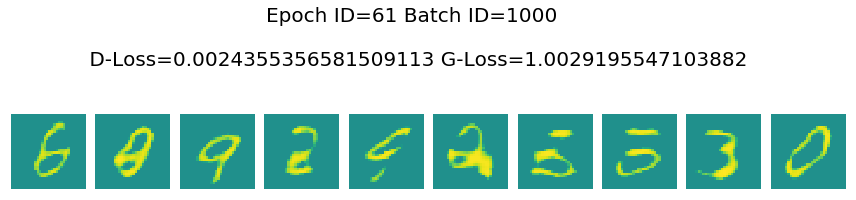

Epoch ID=62 Batch ID=0 

 D-Loss=0.0005318229668773711 G-Loss=1.002866506576538


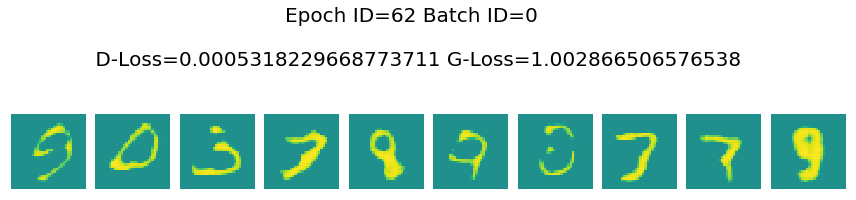

Epoch ID=62 Batch ID=1000 

 D-Loss=0.0005867523141205311 G-Loss=1.0025861263275146


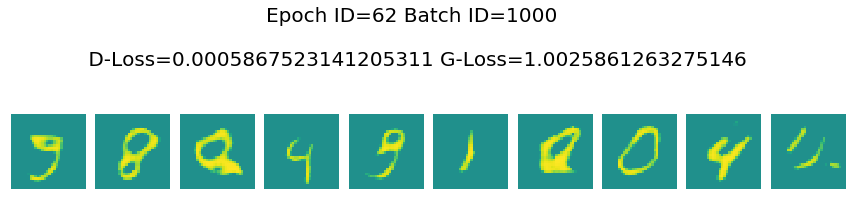

Epoch ID=63 Batch ID=0 

 D-Loss=0.0031052748672664165 G-Loss=0.9991632699966431


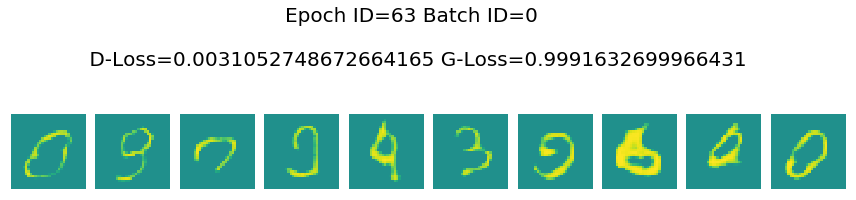

Epoch ID=63 Batch ID=1000 

 D-Loss=0.0005283361533656716 G-Loss=1.004086971282959


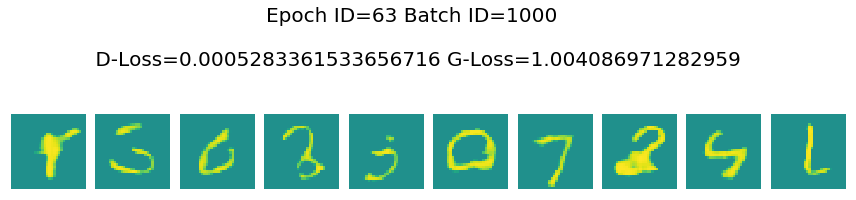

Epoch ID=64 Batch ID=0 

 D-Loss=0.005450764205306768 G-Loss=1.002822995185852


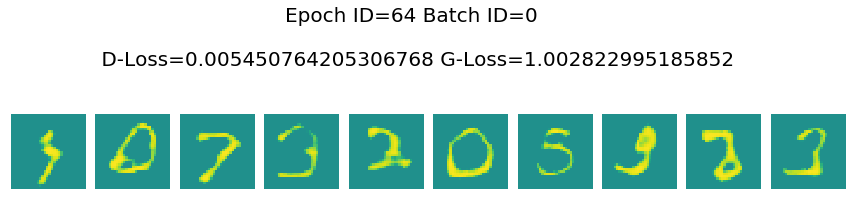

Epoch ID=64 Batch ID=1000 

 D-Loss=0.009055836126208305 G-Loss=1.0093224048614502


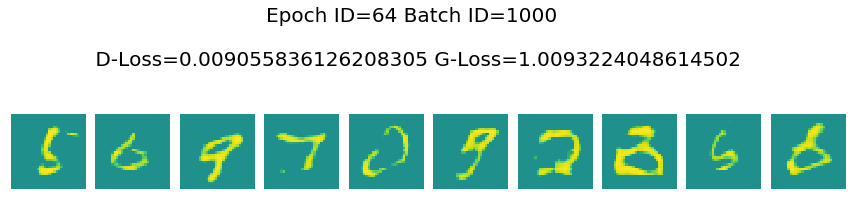

Epoch ID=65 Batch ID=0 

 D-Loss=0.0008215554407797754 G-Loss=1.0030772686004639


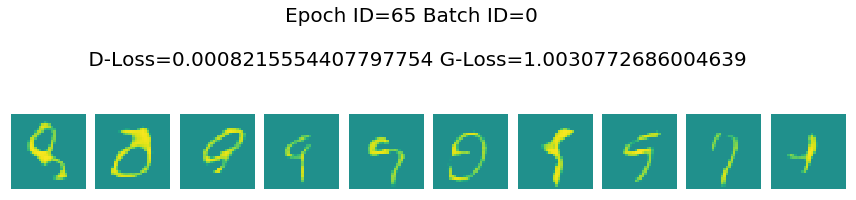

Epoch ID=65 Batch ID=1000 

 D-Loss=0.00047457797336392105 G-Loss=1.0141017436981201


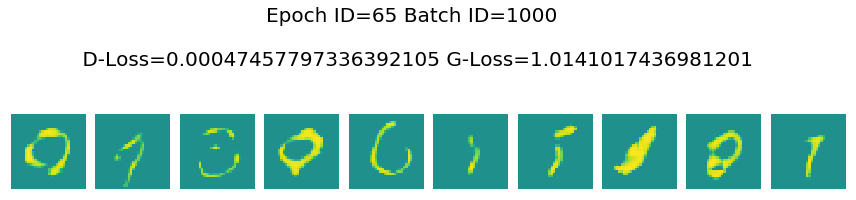

Epoch ID=66 Batch ID=0 

 D-Loss=0.0014202211750671268 G-Loss=1.002582311630249


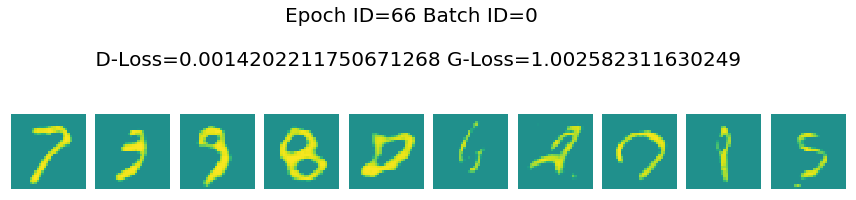

Epoch ID=66 Batch ID=1000 

 D-Loss=0.0008384835673496127 G-Loss=1.0049428939819336


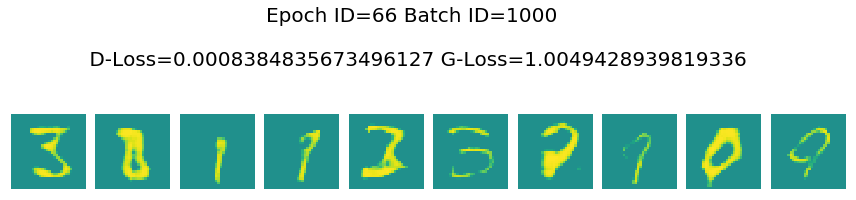

Epoch ID=67 Batch ID=0 

 D-Loss=0.001176314428448677 G-Loss=1.0009570121765137


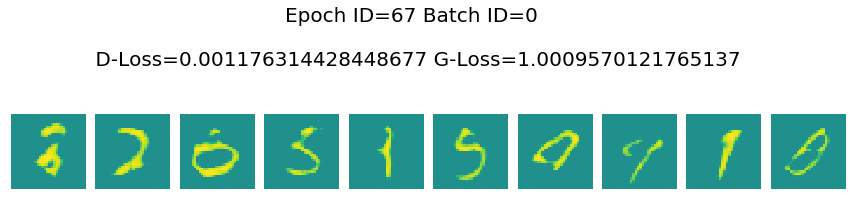

Epoch ID=67 Batch ID=1000 

 D-Loss=0.0006374364020302892 G-Loss=1.02286958694458


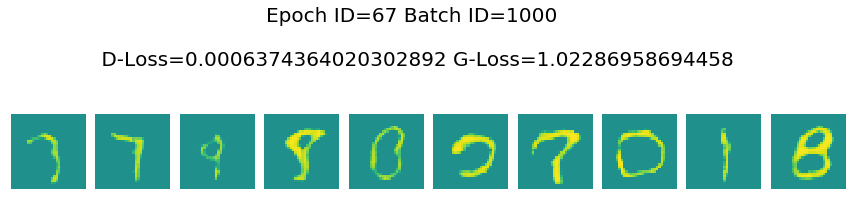

Epoch ID=68 Batch ID=0 

 D-Loss=0.0002910533221438527 G-Loss=1.0048843622207642


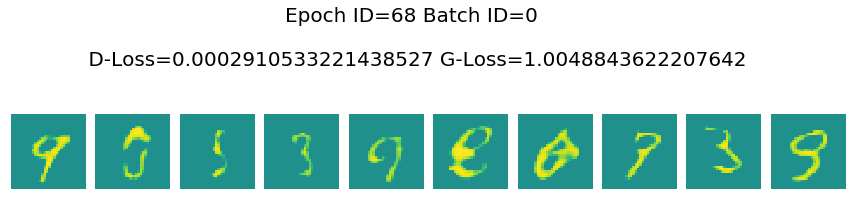

Epoch ID=68 Batch ID=1000 

 D-Loss=0.005363886244595051 G-Loss=1.0063395500183105


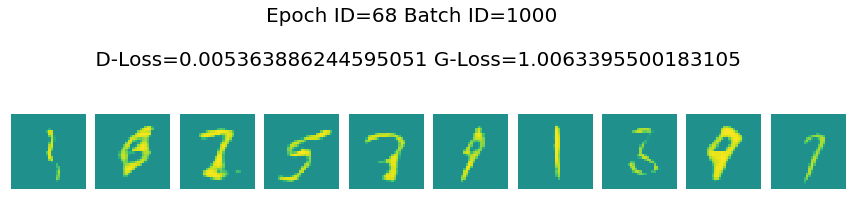

Epoch ID=69 Batch ID=0 

 D-Loss=0.00048725190572440624 G-Loss=0.9986391067504883


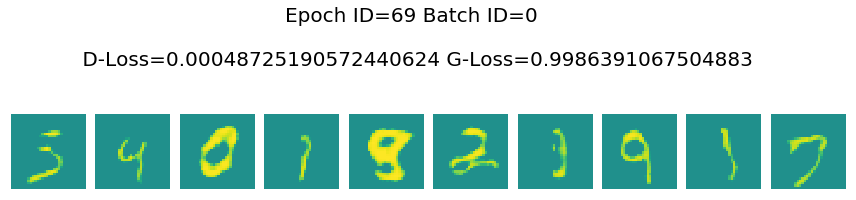

Epoch ID=69 Batch ID=1000 

 D-Loss=0.0016482737846672535 G-Loss=1.0037198066711426


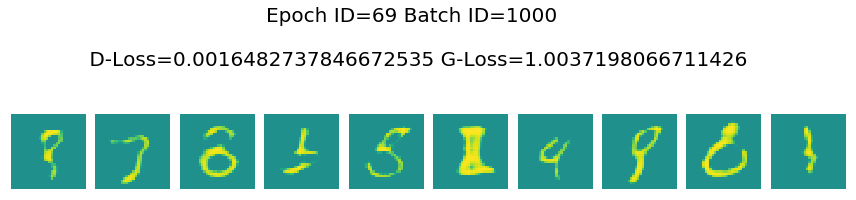

Epoch ID=70 Batch ID=0 

 D-Loss=0.0037884318735450506 G-Loss=1.0007964372634888


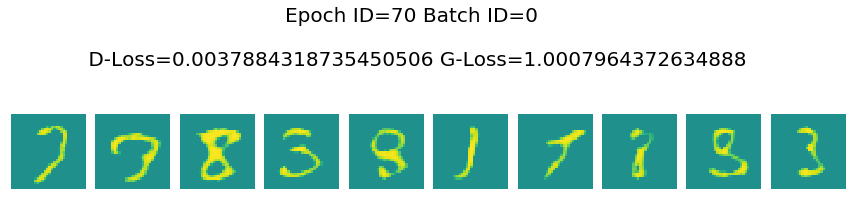

Epoch ID=70 Batch ID=1000 

 D-Loss=0.0016120097134262323 G-Loss=1.0023908615112305


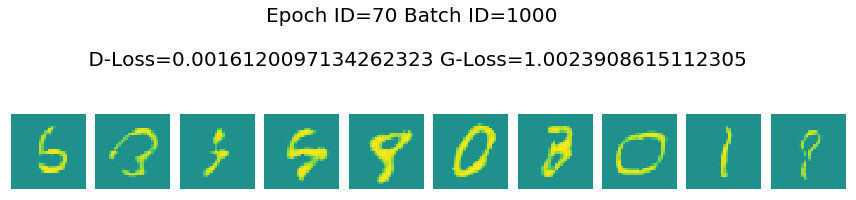

Epoch ID=71 Batch ID=0 

 D-Loss=0.00046897167339921 G-Loss=1.0046806335449219


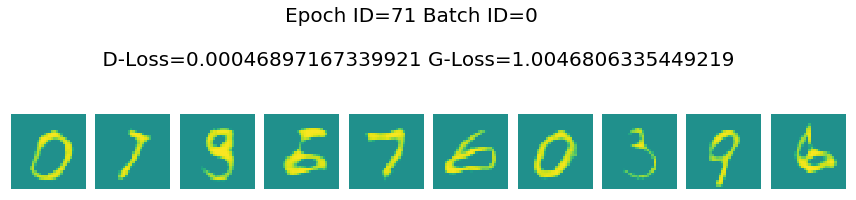

Epoch ID=71 Batch ID=1000 

 D-Loss=0.0021135786082595587 G-Loss=1.0110070705413818


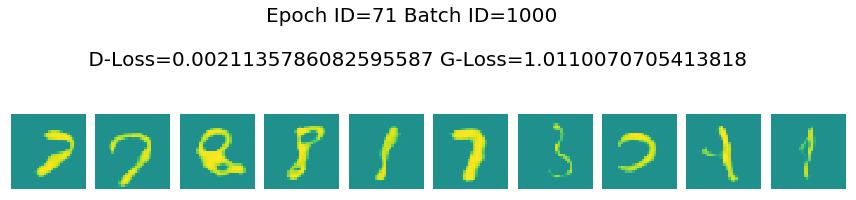

Epoch ID=72 Batch ID=0 

 D-Loss=0.0007179878302849829 G-Loss=1.0104889869689941


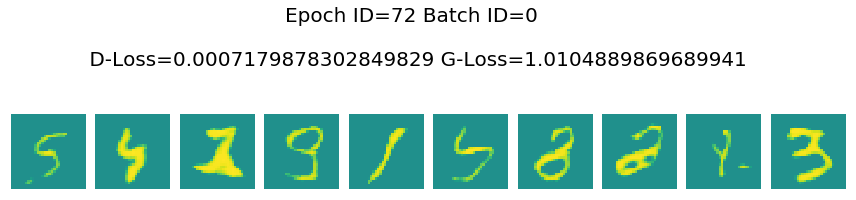

Epoch ID=72 Batch ID=1000 

 D-Loss=0.002526524942368269 G-Loss=1.0031061172485352


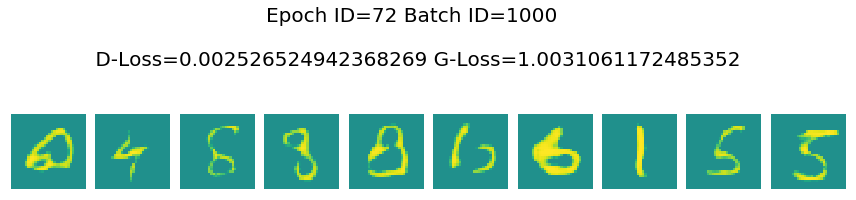

Epoch ID=73 Batch ID=0 

 D-Loss=0.0011350219137966633 G-Loss=1.009694218635559


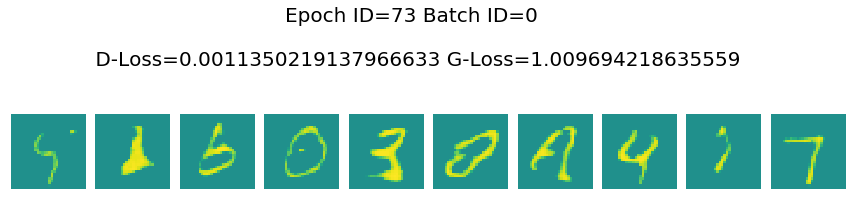

Epoch ID=73 Batch ID=1000 

 D-Loss=0.0009687484125606716 G-Loss=1.0042874813079834


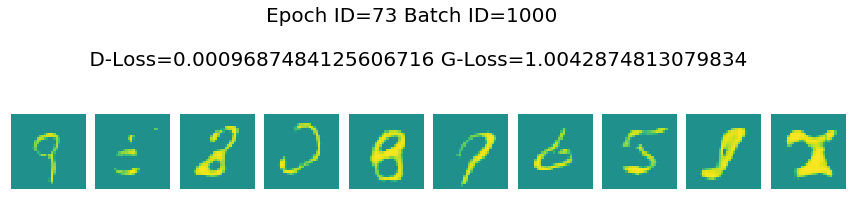

Epoch ID=74 Batch ID=0 

 D-Loss=0.0011143123265355825 G-Loss=1.0074491500854492


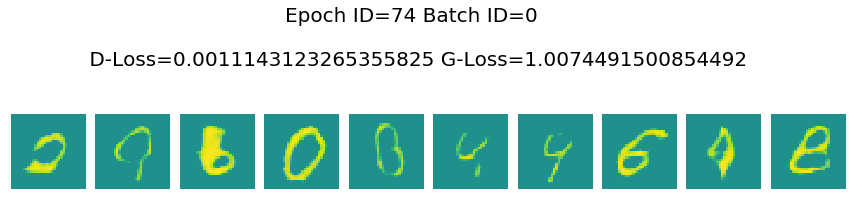

Epoch ID=74 Batch ID=1000 

 D-Loss=0.0005749693373218179 G-Loss=1.0062060356140137


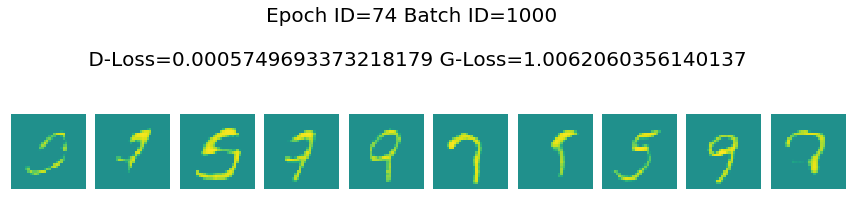

Epoch ID=75 Batch ID=0 

 D-Loss=0.0004964146646670997 G-Loss=1.006709098815918


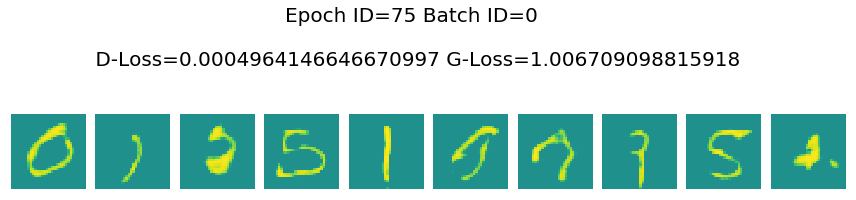

Epoch ID=75 Batch ID=1000 

 D-Loss=0.0019412358524277806 G-Loss=0.9905351400375366


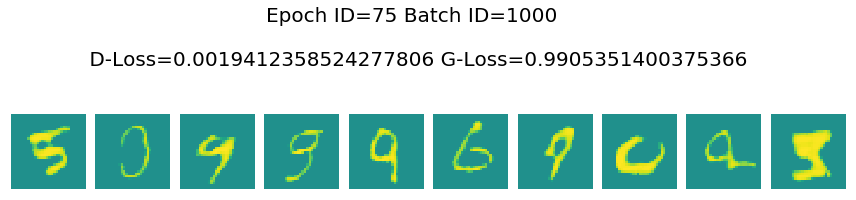

Epoch ID=76 Batch ID=0 

 D-Loss=0.001742939231917262 G-Loss=1.0140808820724487


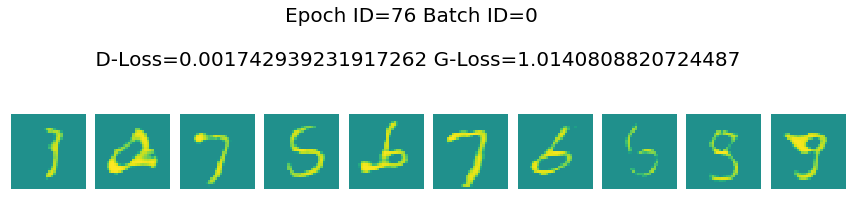

Epoch ID=76 Batch ID=1000 

 D-Loss=0.0009680502698756754 G-Loss=1.0119165182113647


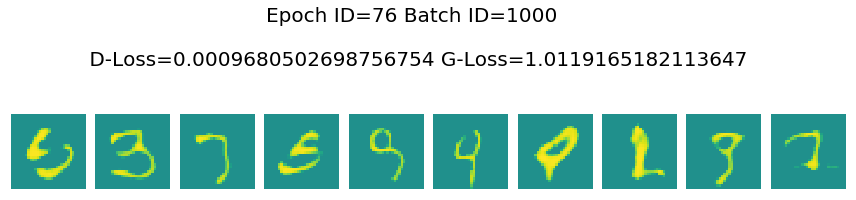

Epoch ID=77 Batch ID=0 

 D-Loss=0.01647065579891205 G-Loss=0.9957079291343689


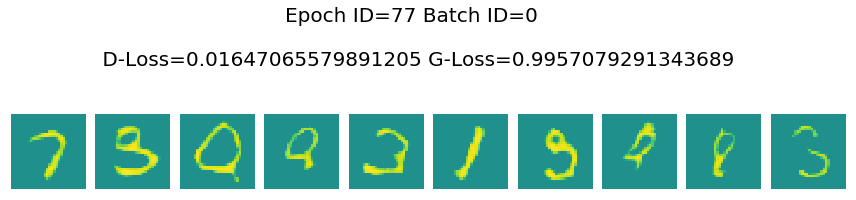

Epoch ID=77 Batch ID=1000 

 D-Loss=0.002036532387137413 G-Loss=1.0017454624176025


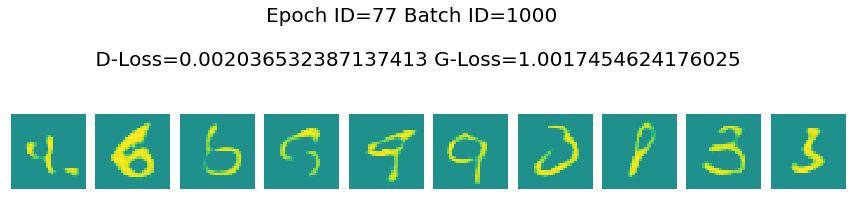

Epoch ID=78 Batch ID=0 

 D-Loss=0.0016156224301084876 G-Loss=1.0025900602340698


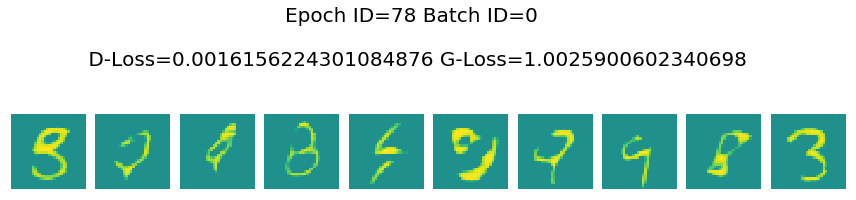

Epoch ID=78 Batch ID=1000 

 D-Loss=0.0006359419785439968 G-Loss=1.0115970373153687


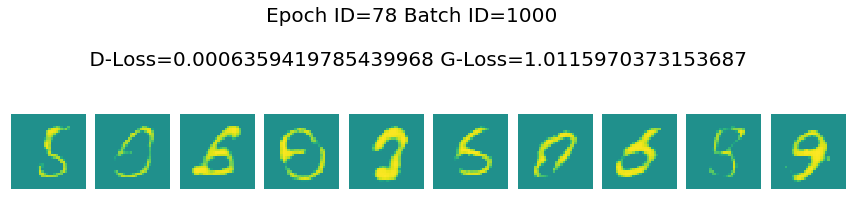

Epoch ID=79 Batch ID=0 

 D-Loss=0.0005080041009932756 G-Loss=1.013139009475708


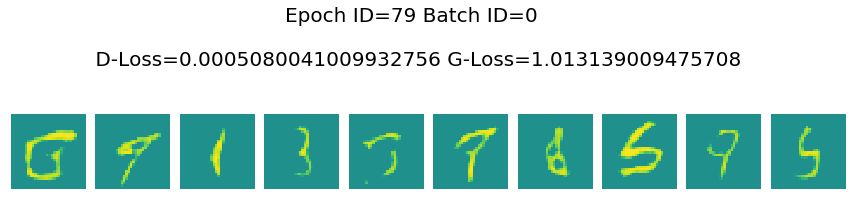

Epoch ID=79 Batch ID=1000 

 D-Loss=0.0008458230877295136 G-Loss=1.0022883415222168


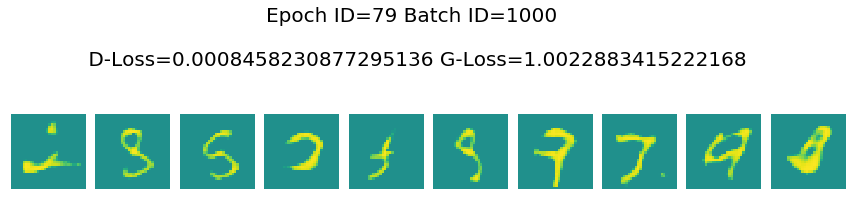

Epoch ID=80 Batch ID=0 

 D-Loss=0.0028946336824446917 G-Loss=1.004124641418457


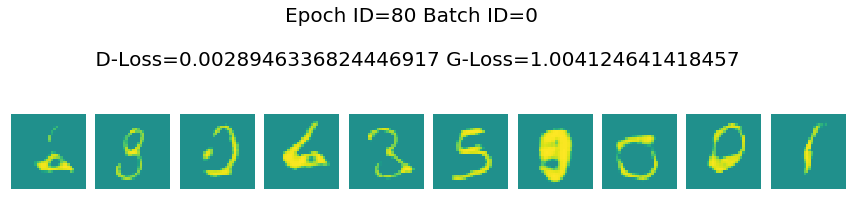

Epoch ID=80 Batch ID=1000 

 D-Loss=0.004548887722194195 G-Loss=1.0048229694366455


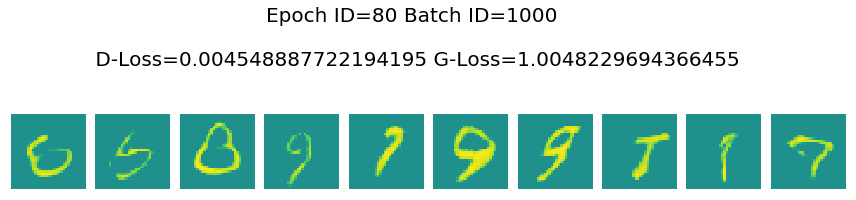

Epoch ID=81 Batch ID=0 

 D-Loss=0.001614726847037673 G-Loss=1.0101373195648193


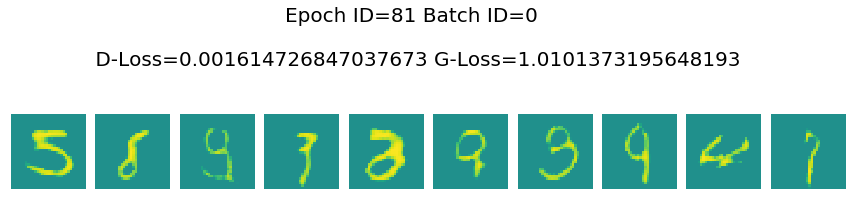

Epoch ID=81 Batch ID=1000 

 D-Loss=0.0046850633807480335 G-Loss=1.0101467370986938


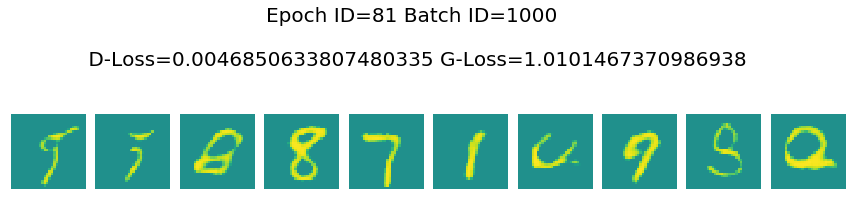

Epoch ID=82 Batch ID=0 

 D-Loss=0.002476889407262206 G-Loss=1.0103427171707153


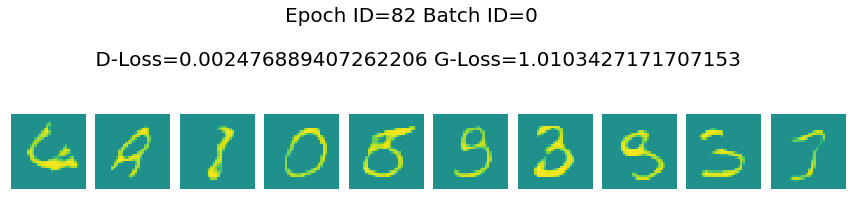

Epoch ID=82 Batch ID=1000 

 D-Loss=0.0007197193335741758 G-Loss=1.0019166469573975


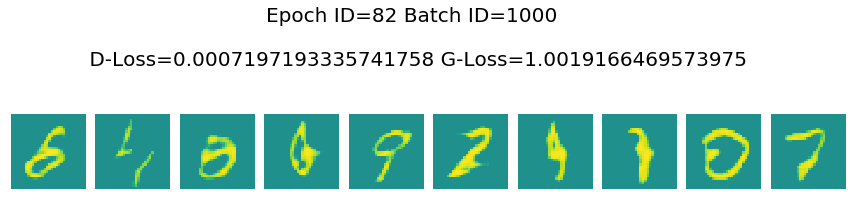

Epoch ID=83 Batch ID=0 

 D-Loss=0.00496964156627655 G-Loss=1.0125088691711426


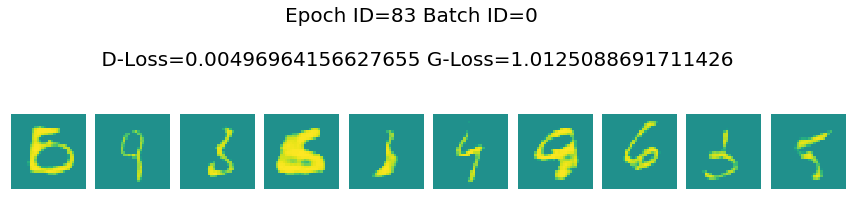

Epoch ID=83 Batch ID=1000 

 D-Loss=0.0003950237878598273 G-Loss=1.0125997066497803


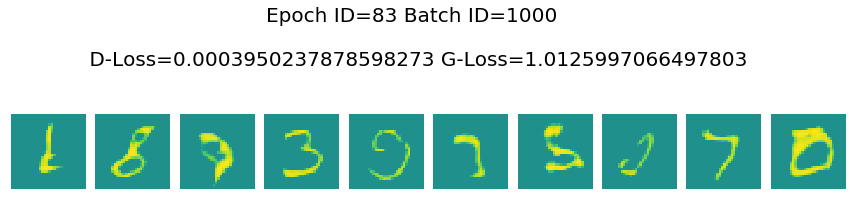

Epoch ID=84 Batch ID=0 

 D-Loss=0.00485309399664402 G-Loss=1.0041930675506592


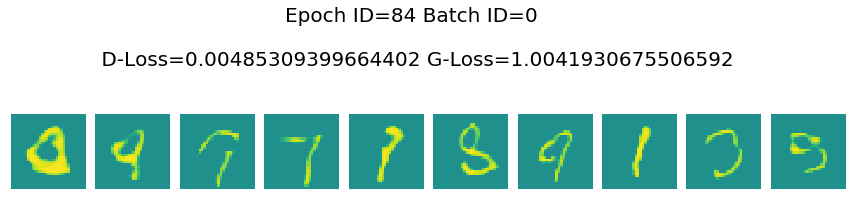

Epoch ID=84 Batch ID=1000 

 D-Loss=0.00023628825147170573 G-Loss=1.0034430027008057


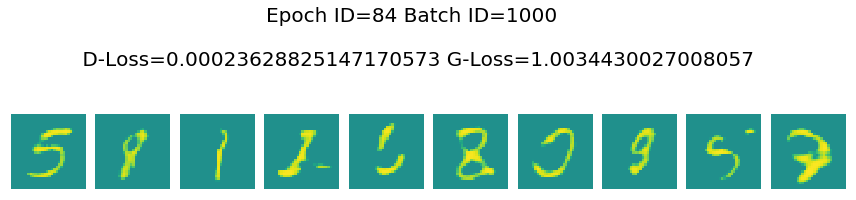

Epoch ID=85 Batch ID=0 

 D-Loss=0.18503142893314362 G-Loss=0.8731279969215393


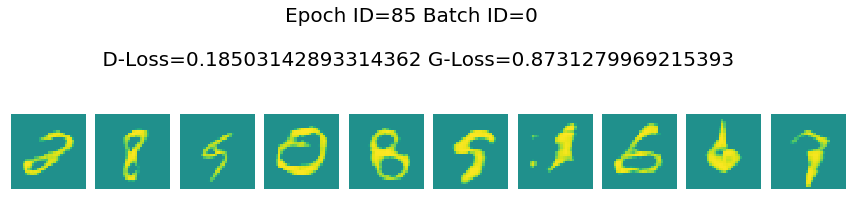

Epoch ID=85 Batch ID=1000 

 D-Loss=0.0004451634595170617 G-Loss=1.0077269077301025


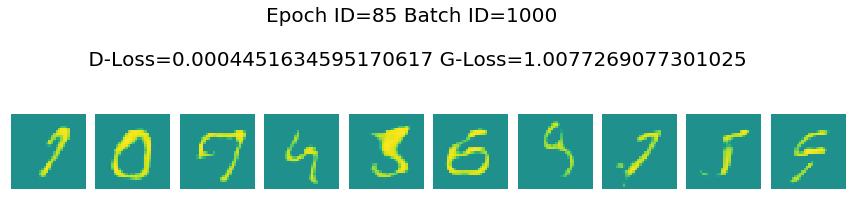

Epoch ID=86 Batch ID=0 

 D-Loss=0.00010395451681688428 G-Loss=0.976281464099884


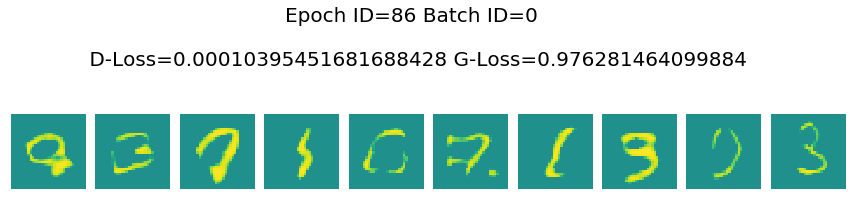

Epoch ID=86 Batch ID=1000 

 D-Loss=0.004856884013861418 G-Loss=1.008253574371338


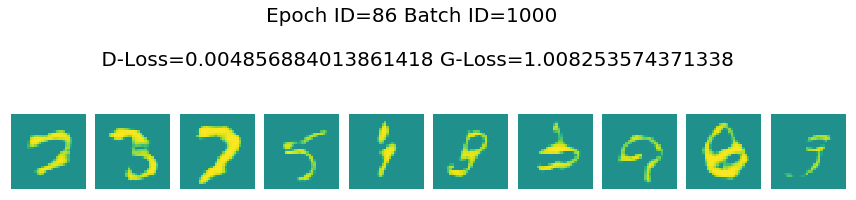

Epoch ID=87 Batch ID=0 

 D-Loss=0.000361717859050259 G-Loss=1.016523838043213


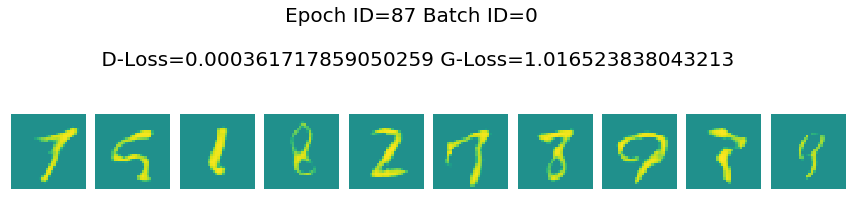

Epoch ID=87 Batch ID=1000 

 D-Loss=0.0015343095874413848 G-Loss=1.0099941492080688


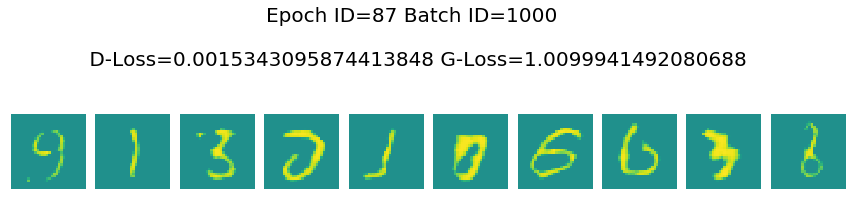

Epoch ID=88 Batch ID=0 

 D-Loss=0.0004233448416925967 G-Loss=1.0050454139709473


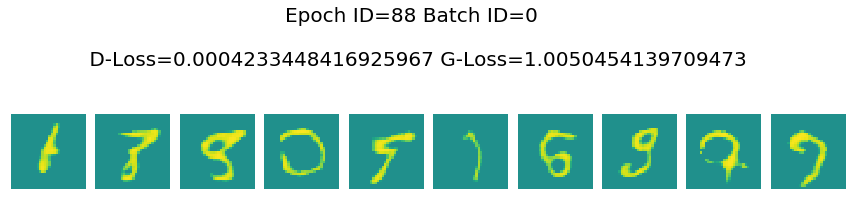

Epoch ID=88 Batch ID=1000 

 D-Loss=0.0018482558662071824 G-Loss=1.0127949714660645


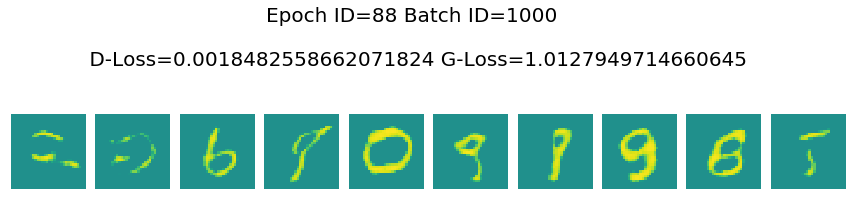

Epoch ID=89 Batch ID=0 

 D-Loss=0.0012281800154596567 G-Loss=1.0058836936950684


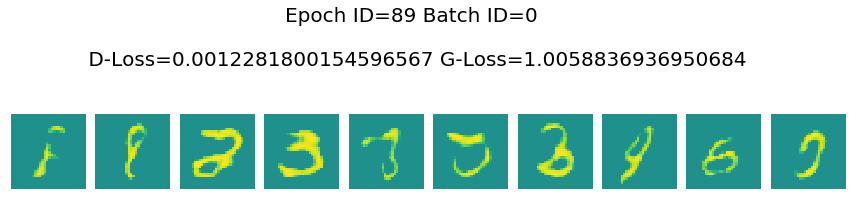

Epoch ID=89 Batch ID=1000 

 D-Loss=0.0006880577420815825 G-Loss=1.0046989917755127


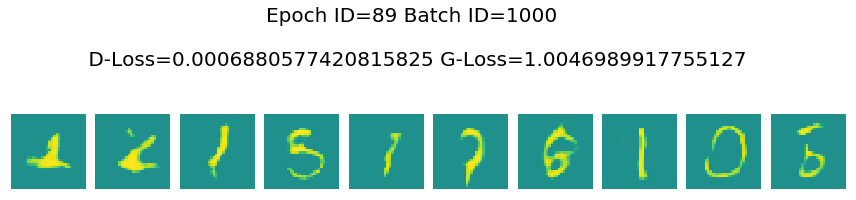

Epoch ID=90 Batch ID=0 

 D-Loss=0.0008729876135475934 G-Loss=1.004565954208374


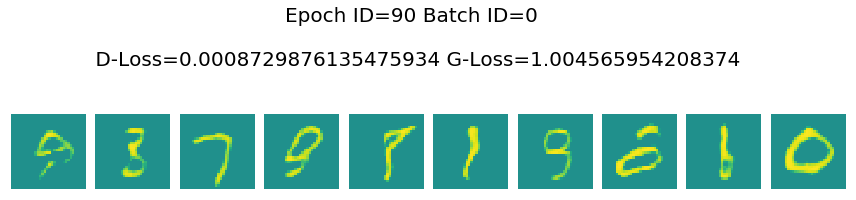

Epoch ID=90 Batch ID=1000 

 D-Loss=0.0005860559758730233 G-Loss=1.0156285762786865


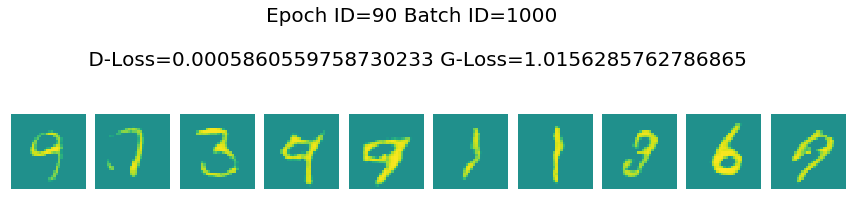

Epoch ID=91 Batch ID=0 

 D-Loss=0.0015530127566307783 G-Loss=1.0044220685958862


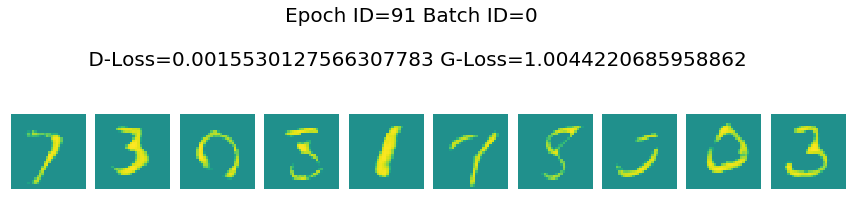

Epoch ID=91 Batch ID=1000 

 D-Loss=0.0005220367456786335 G-Loss=1.003924012184143


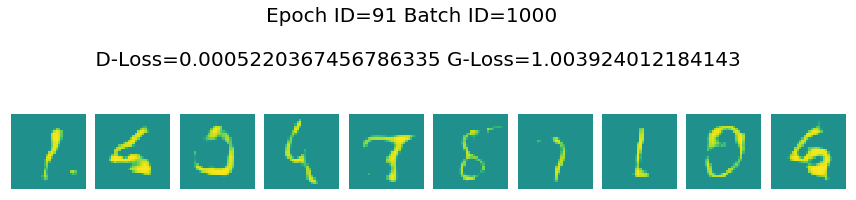

Epoch ID=92 Batch ID=0 

 D-Loss=0.00031028760713525116 G-Loss=1.0025532245635986


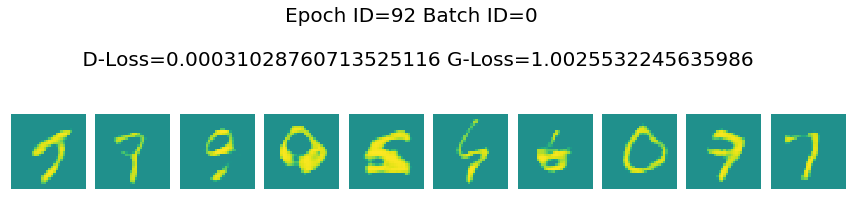

Epoch ID=92 Batch ID=1000 

 D-Loss=0.0001273728412343189 G-Loss=1.0075454711914062


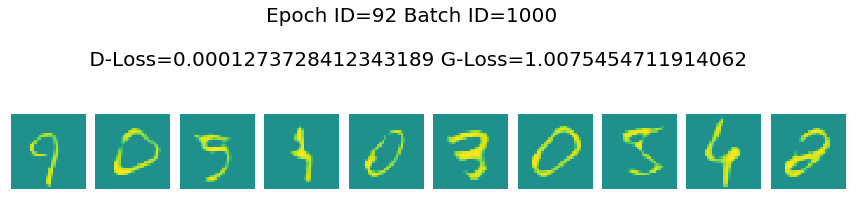

Epoch ID=93 Batch ID=0 

 D-Loss=0.000313326163450256 G-Loss=1.0119328498840332


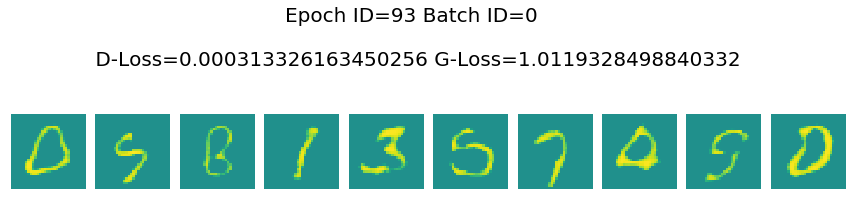

Epoch ID=93 Batch ID=1000 

 D-Loss=0.001371895195916295 G-Loss=1.0093941688537598


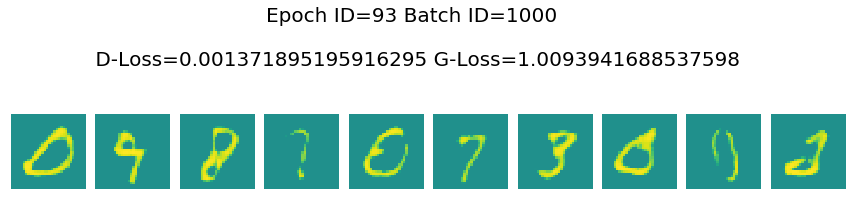

Epoch ID=94 Batch ID=0 

 D-Loss=0.0003095204592682421 G-Loss=1.0104219913482666


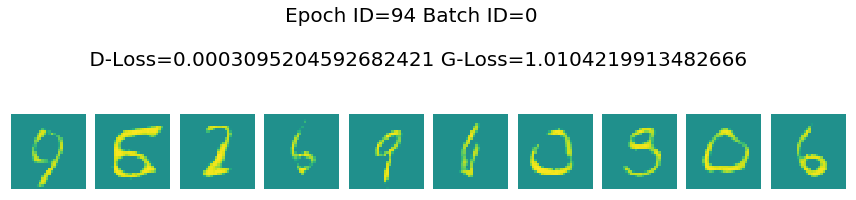

Epoch ID=94 Batch ID=1000 

 D-Loss=0.010949238203465939 G-Loss=1.0069009065628052


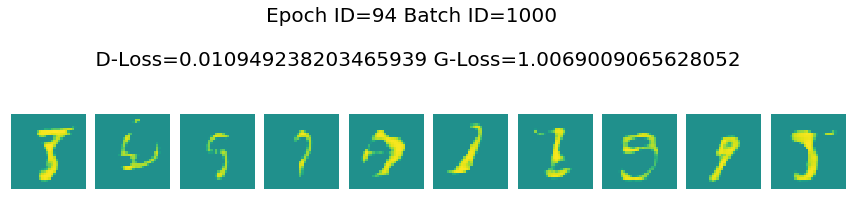

Epoch ID=95 Batch ID=0 

 D-Loss=0.0004285167087800801 G-Loss=1.002974510192871


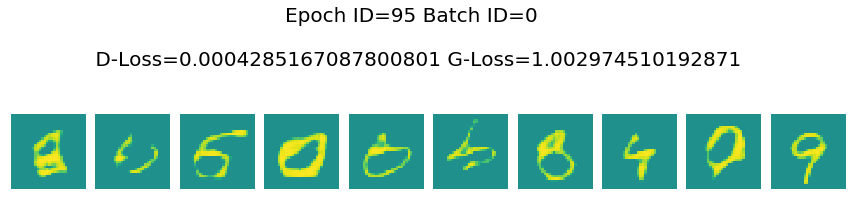

Epoch ID=95 Batch ID=1000 

 D-Loss=0.000941957114264369 G-Loss=1.0140888690948486


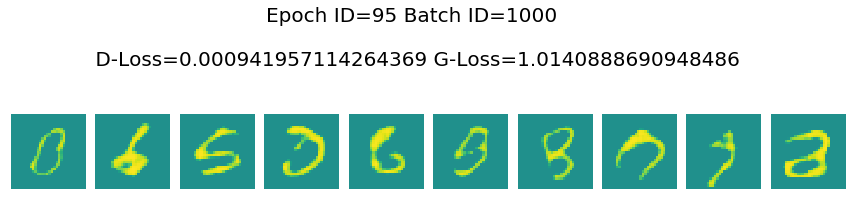

Epoch ID=96 Batch ID=0 

 D-Loss=0.0003758009406737983 G-Loss=1.0074958801269531


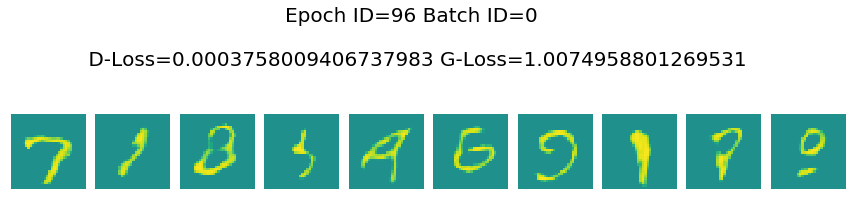

Epoch ID=96 Batch ID=1000 

 D-Loss=0.00042860308894887567 G-Loss=1.0023739337921143


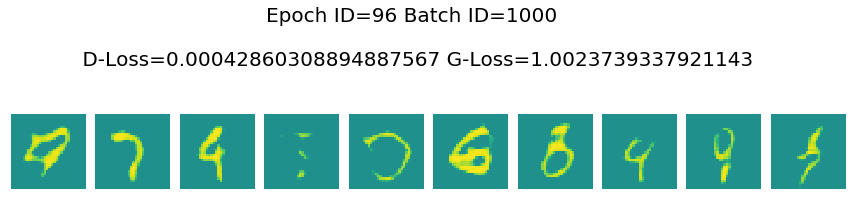

Epoch ID=97 Batch ID=0 

 D-Loss=0.00031474020215682685 G-Loss=1.007231593132019


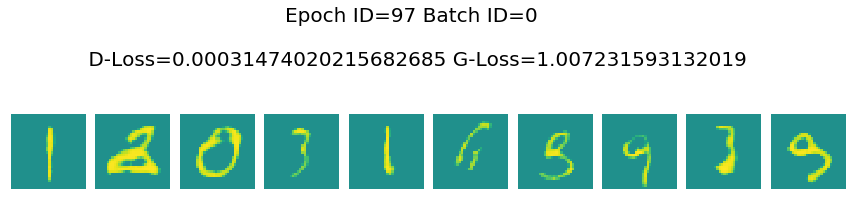

Epoch ID=97 Batch ID=1000 

 D-Loss=0.0011881764512509108 G-Loss=1.0115509033203125


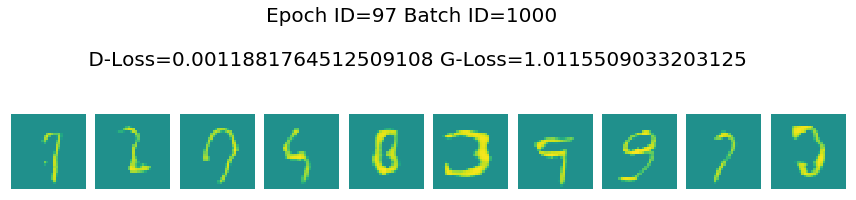

Epoch ID=98 Batch ID=0 

 D-Loss=0.00141882651951164 G-Loss=1.0127103328704834


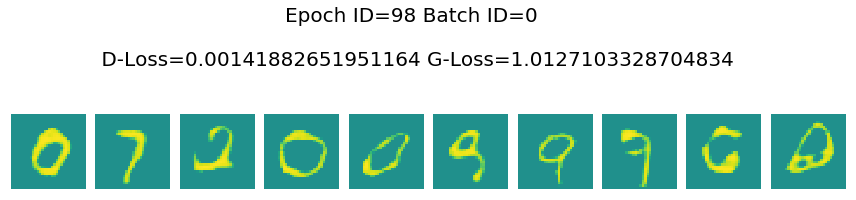

Epoch ID=98 Batch ID=1000 

 D-Loss=0.0015944767510518432 G-Loss=1.0039944648742676


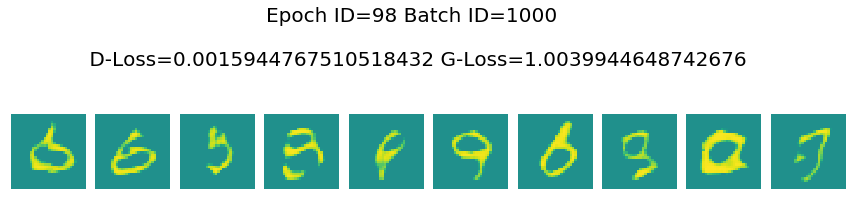

Epoch ID=99 Batch ID=0 

 D-Loss=0.0009196975734084845 G-Loss=1.00736665725708


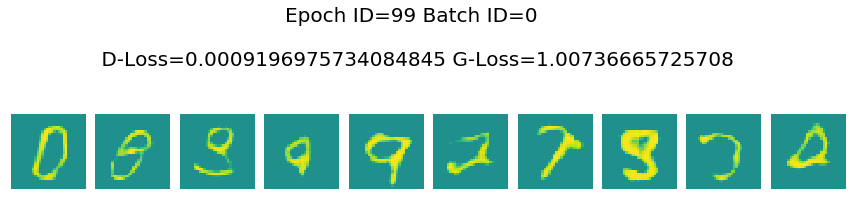

Epoch ID=99 Batch ID=1000 

 D-Loss=0.0015873814700171351 G-Loss=1.0046312808990479


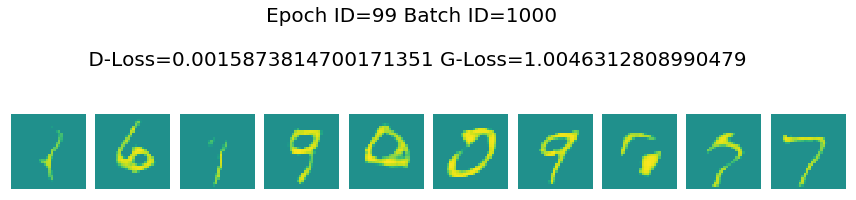

In [8]:
losses = [[], []]
#plt.ion()
now = 0
for pass_id in range(100):
    for batch_id, (data, target) in enumerate(dataloader):#target是数字的标签
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        optimizerD.clear_grad()
        real_img = data
        bs_size = real_img.shape[0]
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype='float32')#创建float32型（bs_size,1,1,1）四维的tensor，元素值为real_leabel
        real_out = netD(real_img)
        errD_real = loss(real_out, label)
        errD_real.backward()

        noise = paddle.randn([bs_size, 100, 1, 1], 'float32')
        fake_img = netG(noise)
        label = paddle.full((bs_size, 1, 1, 1), fake_label, dtype='float32')
        fake_out = netD(fake_img.detach())#不更新netG的权重
        errD_fake = loss(fake_out,label)
        errD_fake.backward()
        optimizerD.step()
        optimizerD.clear_grad()
        errD = errD_real + errD_fake
        losses[0].append(errD.numpy()[0])#将判别器的loss存入losses列表的第一维度中

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerG.clear_grad()
        noise = paddle.randn([bs_size, 100, 1, 1],'float32')
        fake = netG(noise)
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype=np.float32,)
        output = netD(fake)
        errG = loss(output,label)
        errG.backward()
        optimizerG.step()
        optimizerG.clear_grad()

        losses[1].append(errG.numpy()[0])#将生成器的loss存入losses列表的第一维度中


        ############################
        # visualize
        ###########################
        if batch_id % 1000 == 0:
            generated_image = netG(noise).numpy()
            imgs = []
            plt.figure(figsize=(15,15))
            try:
                for i in range(10):
                    image = generated_image[i].transpose()
                    image = np.where(image > 0, image, 0)
                    image = image.transpose((1,0,2))
                    plt.subplot(10, 10, i + 1)

                    plt.imshow(image[...,0], vmin=-1, vmax=1)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(pass_id, batch_id, errD.numpy()[0], errG.numpy()[0])
                print(msg)
                plt.suptitle(msg,fontsize=20)
                plt.draw()
                plt.savefig('{}/{:04d}_{:04d}.png'.format('work', pass_id, batch_id), bbox_inches='tight')
                plt.pause(0.01)
            except IOError:
                print(IOError)
    paddle.save(netG.state_dict(), "work/generator.params")#一个epoch保存一次模型参数

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 